In [1]:
options(repr.matrix.max.rows = 10, repr.matrix.max.cols = 6)


In [2]:
library(dplyr)
library(gridExtra)
library(reshape2)
library(ggplot2)
library(tidyr)
library(tibble)
library(pheatmap)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths




### Notebook outline :
We will be plotting gene expression data measured with Bulk RNA seq from 8 tissues across human and mouse 
1. Loading data
2. Filtering
3. Slicing
4. Transform
5. Merge
6. Save

### 1.Loading Data

In [3]:
mouse <- read.csv('data/mouse_expression.csv.gz', row.names = 1)   
mouse


,mouse_adipose_1,mouse_brain_4,mouse_heart_5,⋯,mouse_lung_1,mouse_pancreas_1,mouse_spleen_4
,<int>,<int>,<int>,⋯,<int>,<int>,<int>
Stag2,3223,3588,1780,⋯,9169,400,10345
Stag1,2750,1429,824,⋯,2242,170,4345
Gosr2,1599,689,259,⋯,912,192,3643
4933434E20Rik,706,683,331,⋯,1226,71,2006
Art5,0,0,5,⋯,0,0,2
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
Fam83e,17,0,0,⋯,19,0,4
Fam83b,63,2,3,⋯,18,5,4
Fam83f,42,2,0,⋯,0,9,42


In [4]:
human <- read.csv('data/human_expression.csv.gz', row.names = 1)
human

,human_adipose_3,human_brain_4,human_heart_2,⋯,human_lung_3,human_pancreas_4,human_spleen_2
,<int>,<int>,<int>,⋯,<int>,<int>,<int>
STAG2,1430,2513,1734,⋯,3690,578,2433
STAG1,835,958,1197,⋯,885,447,787
GOSR2,142,40,187,⋯,63,92,58
C1orf43,1856,3196,4839,⋯,4647,1181,1357
ART5,1,0,17,⋯,6,1,0
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
FAM83E,1,0,0,⋯,4,1,0
FAM83B,3,0,4,⋯,4,16,0
FAM83F,9,3,3,⋯,0,7,0


In [5]:
gene_map <- read.csv('data/human_mouse_gene_map.csv.gz', row.names = 1)
gene_map

,human,mouse
,<chr>,<chr>
Stag2_STAG2,STAG2,Stag2
Stag1_STAG1,STAG1,Stag1
Gosr2_GOSR2,GOSR2,Gosr2
4933434E20Rik_C1orf43,C1orf43,4933434E20Rik
Art5_ART5,ART5,Art5
⋮,⋮,⋮
Fam83e_FAM83E,FAM83E,Fam83e
Fam83b_FAM83B,FAM83B,Fam83b
Fam83f_FAM83F,FAM83F,Fam83f


## 2. Filtering

#### There are no empty experiments / columns

In [6]:
colSums(human)

human_adipose_3    human_brain_4    human_heart_2   human_kidney_2 
        13913058         10131148         32415243          8457567 
   human_liver_2     human_lung_3 human_pancreas_4   human_spleen_2 
        21656293         11545569          6116793          6799719

#### Are there genes with no values across all tissues ?

In [7]:
gene_count_across_tissues <- rowSums(human)
head(gene_count_across_tissues)

STAG2   STAG1   GOSR2 C1orf43    ART5    ART1 
  14799    6250     723   21819      25       5

In [8]:
summary(gene_count_across_tissues)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0     205    1463    7531    4833 7534021 

#### 674 genes have no expression in any tissue
#### 14070 genes are expressed in at least 1 tissue

In [9]:
summary(gene_count_across_tissues == 0)

   Mode   FALSE    TRUE 
logical   14070     674 

## 3.Slicing

#### Find brain columns and DLX rows


In [10]:
brain_cols <- colnames(human)[grep("brain", colnames(human))]
brain_cols


[1] "human_brain_4"

In [11]:
dlx_rows <- rownames(human)[grep("DLX", rownames(human))]
dlx_rows

[1] "DLX4" "DLX5" "DLX3" "DLX6" "DLX1" "DLX2"

#### Extract subset of data

In [12]:
human[dlx_rows, brain_cols]

[1]   0  55   0 142  24   4

## 4. Transform data

### Raw gene counts count expression is dominated by outliers

In [13]:
human_long <- as.data.frame(human) %>%
  rownames_to_column("Gene") %>%
  pivot_longer(-Gene, names_to = "Sample", values_to = "Expression")

# Create boxplot
boxplot_human <- ggplot(human_long, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_boxplot(outlier.shape = 21, outlier.colour = "black", outlier.fill = "white", color = "black") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
    title = "Box Plot of expression by samples",
    x = "Tissue sample",
    y = "Expression"
  ) +
  theme(legend.position = "none")


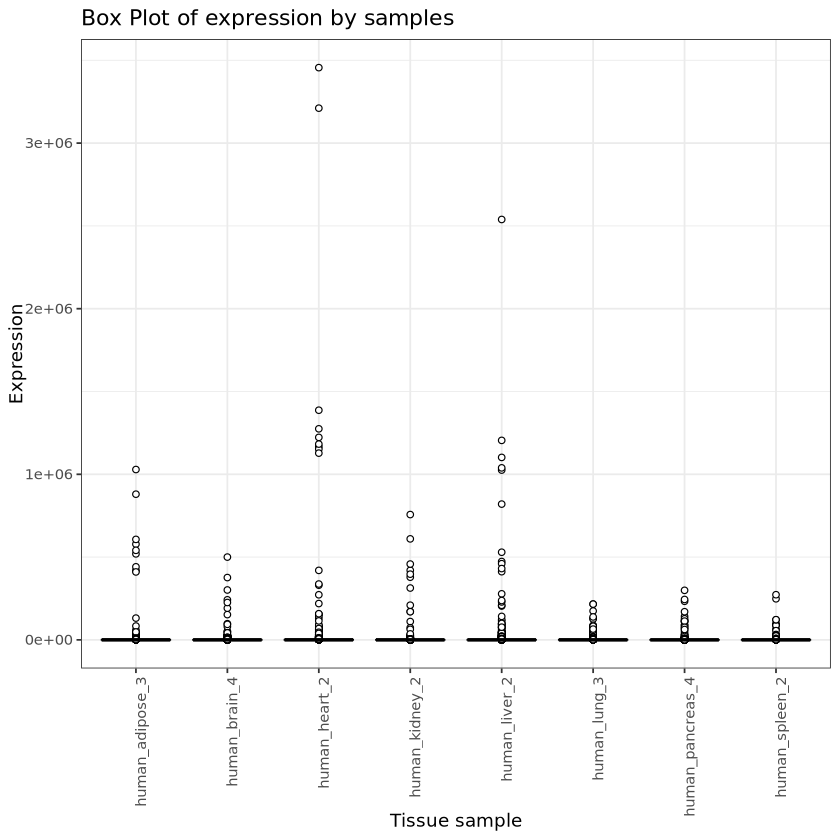

In [14]:
boxplot_human

### RNA seq data follows a log normal distribution

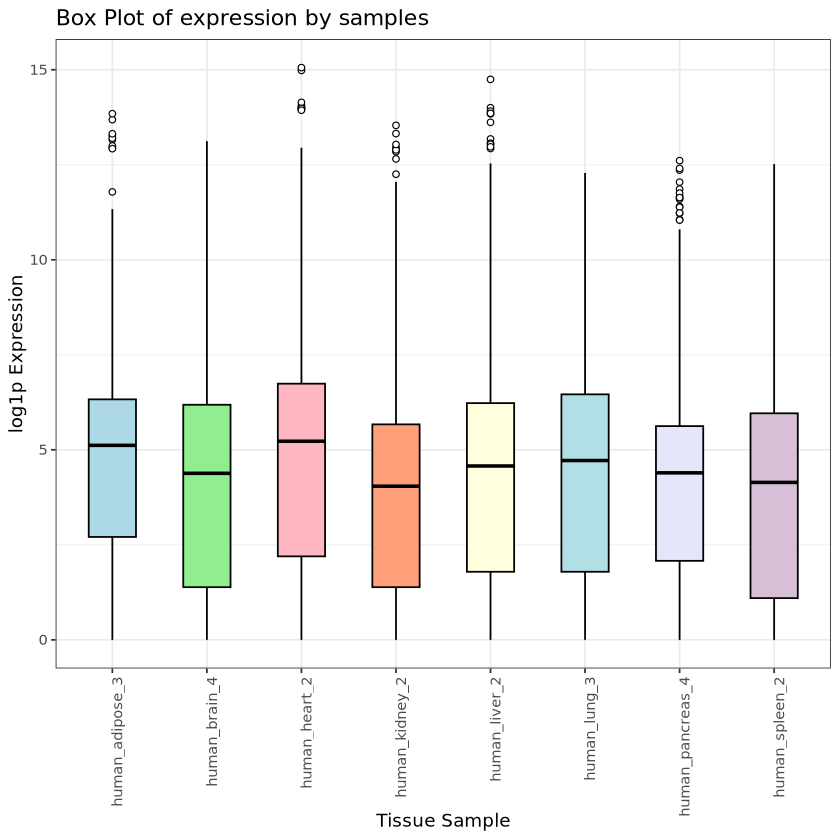

In [15]:
log1p_human <- log1p(human)
log1p_human_long <- as.data.frame(log1p_human) %>%
  rownames_to_column("Gene") %>%
  pivot_longer(-Gene, names_to = "Sample", values_to = "Expression")

# Define pastel color palette
sample_colors <- c(
    "lightblue",     # Soft blue
    "lightgreen",    # Soft green
    "lightpink",     # Soft pink
    "lightsalmon",   # Soft orange-pink
    "lightyellow",   # Pale yellow
    "powderblue",    # Light gray-blue
    "lavender",      # Light purple
    "thistle"        # Soft lavender-pink
)

# Create boxplot with pastel colors
ggplot(log1p_human_long, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_boxplot(width = 0.5, outlier.shape = 21, outlier.colour = "black", outlier.fill = "white", color = "black") +
  scale_fill_manual(values = sample_colors) +  # use pastel colors
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
    title = "Box Plot of expression by samples",
    x = "Tissue Sample",
    y = "log1p Expression"
  ) +
  theme(legend.position = "none")



### Accounting for sequencing depth removes some batch effect

In [16]:
normed_human <- t(t(human) / colSums(human)) * 1e6
normed_human[dlx_rows,]

,human_adipose_3,human_brain_4,human_heart_2,⋯,human_lung_3,human_pancreas_4,human_spleen_2
DLX4,0.64687432,0.000000,0.00000000,⋯,1.6456530,0.3269687,0.5882596
DLX5,0.35937462,5.428802,0.03084968,⋯,0.0000000,0.0000000,0.1470649
DLX3,0.35937462,0.000000,0.00000000,⋯,0.1732266,0.9809062,0.0000000
DLX6,0.28749970,14.016181,0.00000000,⋯,0.0000000,0.0000000,0.0000000
DLX1,0.14374985,2.368932,0.06169937,⋯,0.0000000,0.1634844,0.0000000
DLX2,0.07187492,0.394822,0.00000000,⋯,0.0000000,0.0000000,0.0000000


In [17]:
human[dlx_rows,]

,human_adipose_3,human_brain_4,human_heart_2,⋯,human_lung_3,human_pancreas_4,human_spleen_2
,<int>,<int>,<int>,⋯,<int>,<int>,<int>
DLX4,9,0,0,⋯,19,2,4
DLX5,5,55,1,⋯,0,0,1
DLX3,5,0,0,⋯,2,6,0
DLX6,4,142,0,⋯,0,0,0
DLX1,2,24,2,⋯,0,1,0
DLX2,1,4,0,⋯,0,0,0


In [18]:
ref <- "human_brain_4"
normed_human[dlx_rows,ref]




DLX4      DLX5      DLX3      DLX6      DLX1      DLX2 
 0.000000  5.428802  0.000000 14.016181  2.368932  0.394822

In [19]:
ref <- "human_brain_4"

a <- normed_human[dlx_rows,ref]

# Get all columns except reference
col_subset <- colnames(normed_human)[colnames(normed_human) != ref]
# Calculate fold changes
normed_human_fold_changes <- sapply(col_subset, function(c) {
    b <- normed_human[dlx_rows, c]
    (b - a) / a
})

normed_human_fold_changes


,human_adipose_3,human_heart_2,human_kidney_2,⋯,human_lung_3,human_pancreas_4,human_spleen_2
DLX4,Inf,NaN,NaN,⋯,Inf,Inf,Inf
DLX5,-0.9338022,-0.9943174,-1,⋯,-1,-1.0000000,-0.9729102
DLX3,Inf,NaN,Inf,⋯,Inf,Inf,NaN
DLX6,-0.9794880,-1.0000000,-1,⋯,-1,-1.0000000,-1.0000000
DLX1,-0.9393187,-0.9739548,-1,⋯,-1,-0.9309882,-1.0000000
DLX2,-0.8179561,-1.0000000,-1,⋯,-1,-1.0000000,-1.0000000


In [20]:
# Replace NA with 0
normed_human_fold_changes[is.na(normed_human_fold_changes)] <- 0
inf_mask <- is.infinite(normed_human_fold_changes)
normed_human_fold_changes[inf_mask] <- human[dlx_rows, col_subset][inf_mask]

normed_human_fold_changes[is.na(normed_human_fold_changes)] <- 0

inf_mask <- is.infinite(normed_human_fold_changes)
normed_human_fold_changes[inf_mask] <- human[dlx_rows, col_subset][inf_mask]


# Convert to data frame while preserving row names
normed_human_fold_changes <- as.data.frame(normed_human_fold_changes, row.names = dlx_rows)
normed_human_fold_changes

,human_adipose_3,human_heart_2,human_kidney_2,⋯,human_lung_3,human_pancreas_4,human_spleen_2
,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>
DLX4,9.0000000,0.0000000,0,⋯,19,2.0000000,4.0000000
DLX5,-0.9338022,-0.9943174,-1,⋯,-1,-1.0000000,-0.9729102
DLX3,5.0000000,0.0000000,1,⋯,2,6.0000000,0.0000000
DLX6,-0.9794880,-1.0000000,-1,⋯,-1,-1.0000000,-1.0000000
DLX1,-0.9393187,-0.9739548,-1,⋯,-1,-0.9309882,-1.0000000
DLX2,-0.8179561,-1.0000000,-1,⋯,-1,-1.0000000,-1.0000000


In [21]:
ref <- "human_brain_4"

a <- human[dlx_rows,ref]

# Get all columns except reference
col_subset <- colnames(human)[colnames(human) != ref]
# Calculate fold changes
human_fold_changes <- sapply(col_subset, function(c) {
    b <- normed_human[dlx_rows, c]
    (b - a) / a
})

human_fold_changes[is.na(human_fold_changes)] <- 0

inf_mask <- is.infinite(human_fold_changes)
human_fold_changes[inf_mask] <- human[dlx_rows, col_subset][inf_mask]


human_fold_changes


,human_adipose_3,human_heart_2,human_kidney_2,⋯,human_lung_3,human_pancreas_4,human_spleen_2
DLX4,9.0000000,0.0000000,0,⋯,19,2.0000000,4.0000000
DLX5,-0.9934659,-0.9994391,-1,⋯,-1,-1.0000000,-0.9973261
DLX3,5.0000000,0.0000000,1,⋯,2,6.0000000,0.0000000
DLX6,-0.9979754,-1.0000000,-1,⋯,-1,-1.0000000,-1.0000000
DLX1,-0.9940104,-0.9974292,-1,⋯,-1,-0.9931882,-1.0000000
DLX2,-0.9820313,-1.0000000,-1,⋯,-1,-1.0000000,-1.0000000


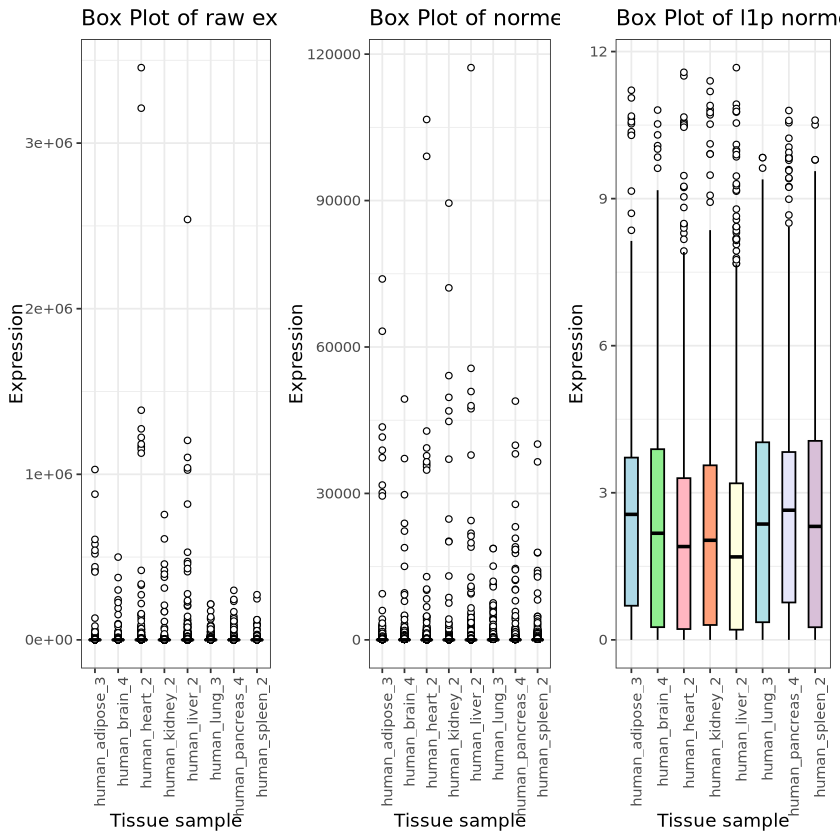

In [22]:
human_long <- as.data.frame(human) %>%
  rownames_to_column("Gene") %>%
  pivot_longer(-Gene, names_to = "Sample", values_to = "Expression")

# Create boxplot
boxplot_human <- ggplot(human_long, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_boxplot(width = 0.5, outlier.shape = 21, outlier.colour = "black", outlier.fill = "white", color = "black") +
  scale_fill_manual(values = sample_colors) +  # use pastel colors
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
    title = "Box Plot of raw expression by samples",
    x = "Tissue sample",
    y = "Expression"
  ) +
  theme(legend.position = "none")


normed_human_long <- as.data.frame(normed_human) %>%
  rownames_to_column("Gene") %>%
  pivot_longer(-Gene, names_to = "Sample", values_to = "Expression")

# Create boxplot
boxplot_normed_human <- ggplot(normed_human_long, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_boxplot(width = 0.5, outlier.shape = 21, outlier.colour = "black", outlier.fill = "white", color = "black") +
  scale_fill_manual(values = sample_colors) +  # use pastel colors
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
    title = "Box Plot of normed expression by samples",
    x = "Tissue sample",
    y = "Expression"
  ) +
  theme(legend.position = "none")


log1p_normed_human <- log1p(normed_human)

log1p_normed_human_long <- as.data.frame(log1p_normed_human) %>%
  rownames_to_column("Gene") %>%
  pivot_longer(-Gene, names_to = "Sample", values_to = "Expression")

# Create boxplot
boxplot_log1p_normed_human <- ggplot(log1p_normed_human_long, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_boxplot(width = 0.5, outlier.shape = 21, outlier.colour = "black", outlier.fill = "white", color = "black") +
  scale_fill_manual(values = sample_colors) +  # use pastel colors
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
    title = "Box Plot of l1p normed expression by samples",
    x = "Tissue sample",
    y = "Expression"
  ) +
  theme(legend.position = "none")

grid.arrange(boxplot_human, boxplot_normed_human, boxplot_log1p_normed_human, ncol = 3)



In [23]:
options(repr.plot.width = 18, repr.plot.height = 6)

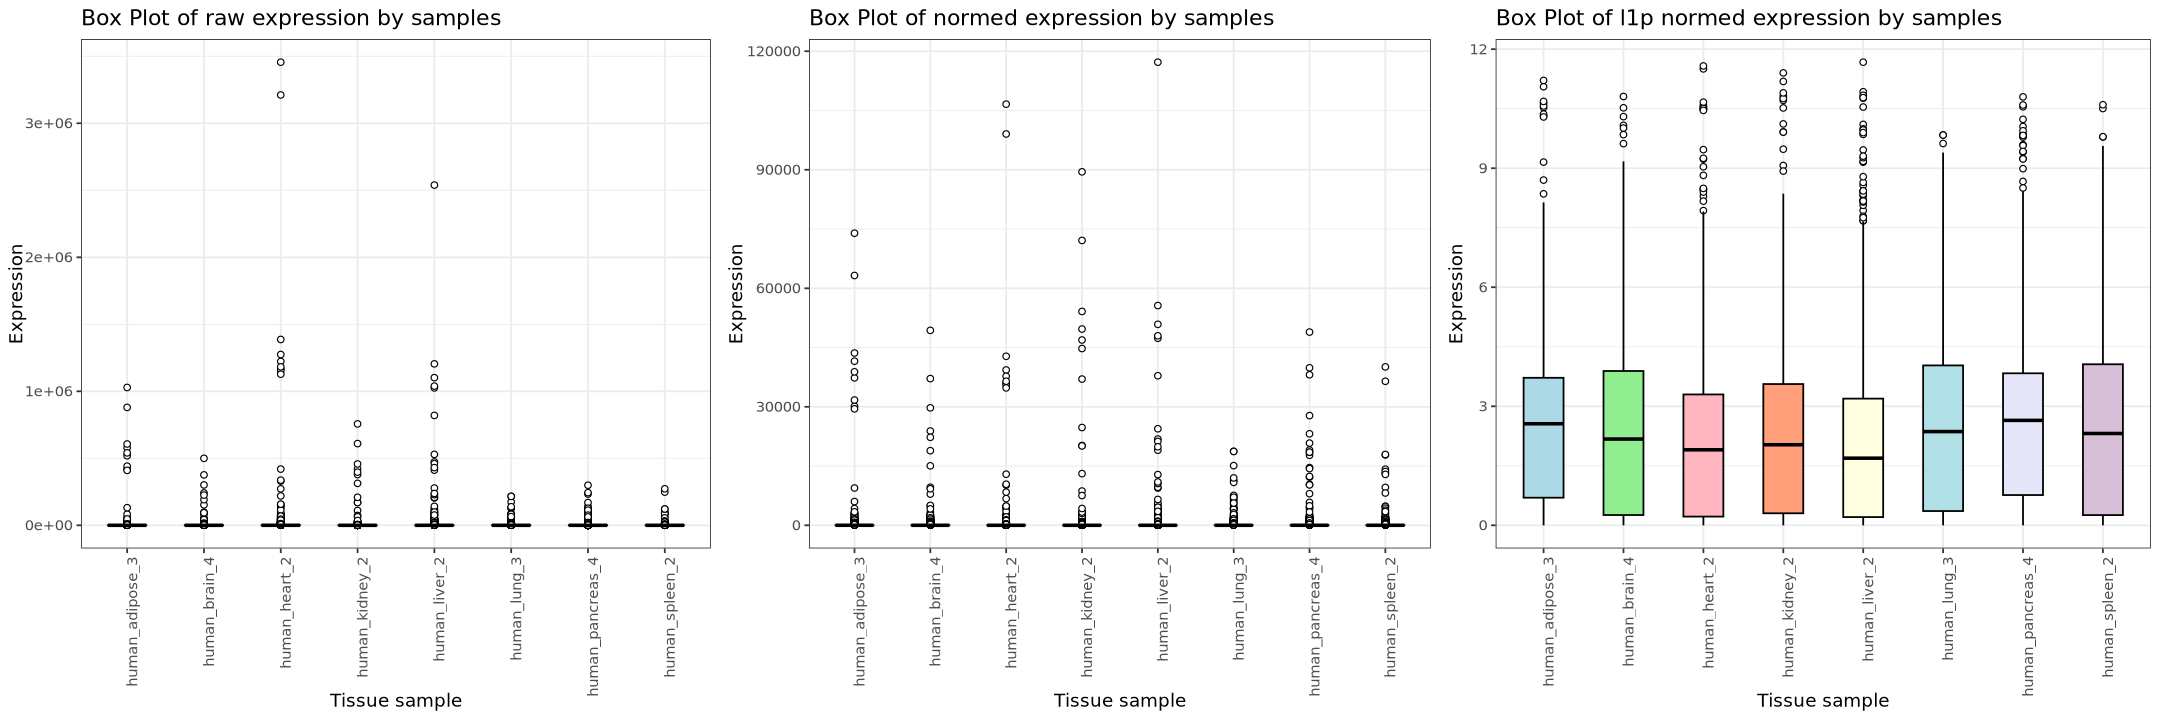

In [24]:
grid.arrange(boxplot_human, boxplot_normed_human, boxplot_log1p_normed_human, ncol = 3)

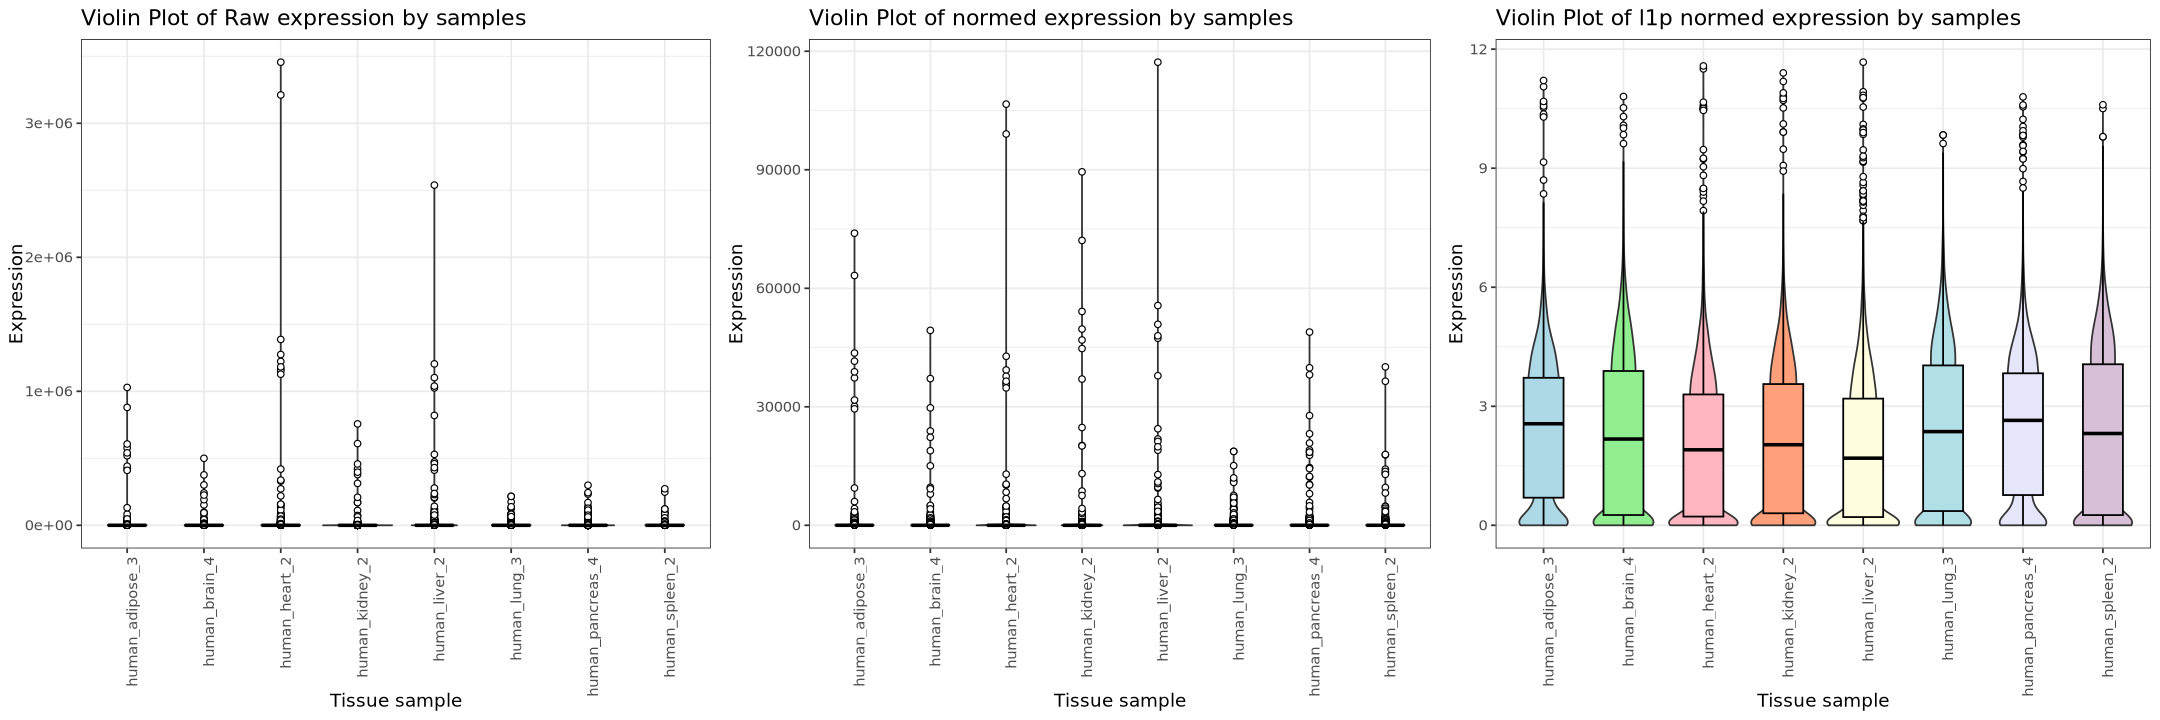

In [25]:
human_long <- as.data.frame(human) %>%
  rownames_to_column("Gene") %>%
  pivot_longer(-Gene, names_to = "Sample", values_to = "Expression")

# Create boxplot
violinplot_human <- ggplot(human_long, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_violin()+
  geom_boxplot(width = 0.5, outlier.shape = 21, outlier.colour = "black", outlier.fill = "white", color = "black") +
  scale_fill_manual(values = sample_colors) +  # use pastel colors
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
    title = "Violin Plot of Raw expression by samples",
    x = "Tissue sample",
    y = "Expression"
  ) +
  theme(legend.position = "none")


normed_human_long <- as.data.frame(normed_human) %>%
  rownames_to_column("Gene") %>%
  pivot_longer(-Gene, names_to = "Sample", values_to = "Expression")

# Create boxplot
violinplot_normed_human <- ggplot(normed_human_long, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_violin()+
  geom_boxplot(width = 0.5, outlier.shape = 21, outlier.colour = "black", outlier.fill = "white", color = "black") +
  scale_fill_manual(values = sample_colors) +  # use pastel colors
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
    title = "Violin Plot of normed expression by samples",
    x = "Tissue sample",
    y = "Expression"
  ) +
  theme(legend.position = "none")


log1p_normed_human <- log1p(normed_human)

log1p_normed_human_long <- as.data.frame(log1p_normed_human) %>%
  rownames_to_column("Gene") %>%
  pivot_longer(-Gene, names_to = "Sample", values_to = "Expression")

# Create boxplot
violinplot_log1p_normed_human <- ggplot(log1p_normed_human_long, aes(x = Sample, y = Expression, fill = Sample)) +
  geom_violin()+
  geom_boxplot(width = 0.5, outlier.shape = 21, outlier.colour = "black", outlier.fill = "white", color = "black") +
  scale_fill_manual(values = sample_colors) +  # use pastel colors
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(
    title = "Violin Plot of l1p normed expression by samples",
    x = "Tissue sample",
    y = "Expression"
  ) +
  theme(legend.position = "none")

grid.arrange(violinplot_human, violinplot_normed_human, violinplot_log1p_normed_human, ncol = 3)



In [26]:
options(repr.plot.width = 18, repr.plot.height = 12)

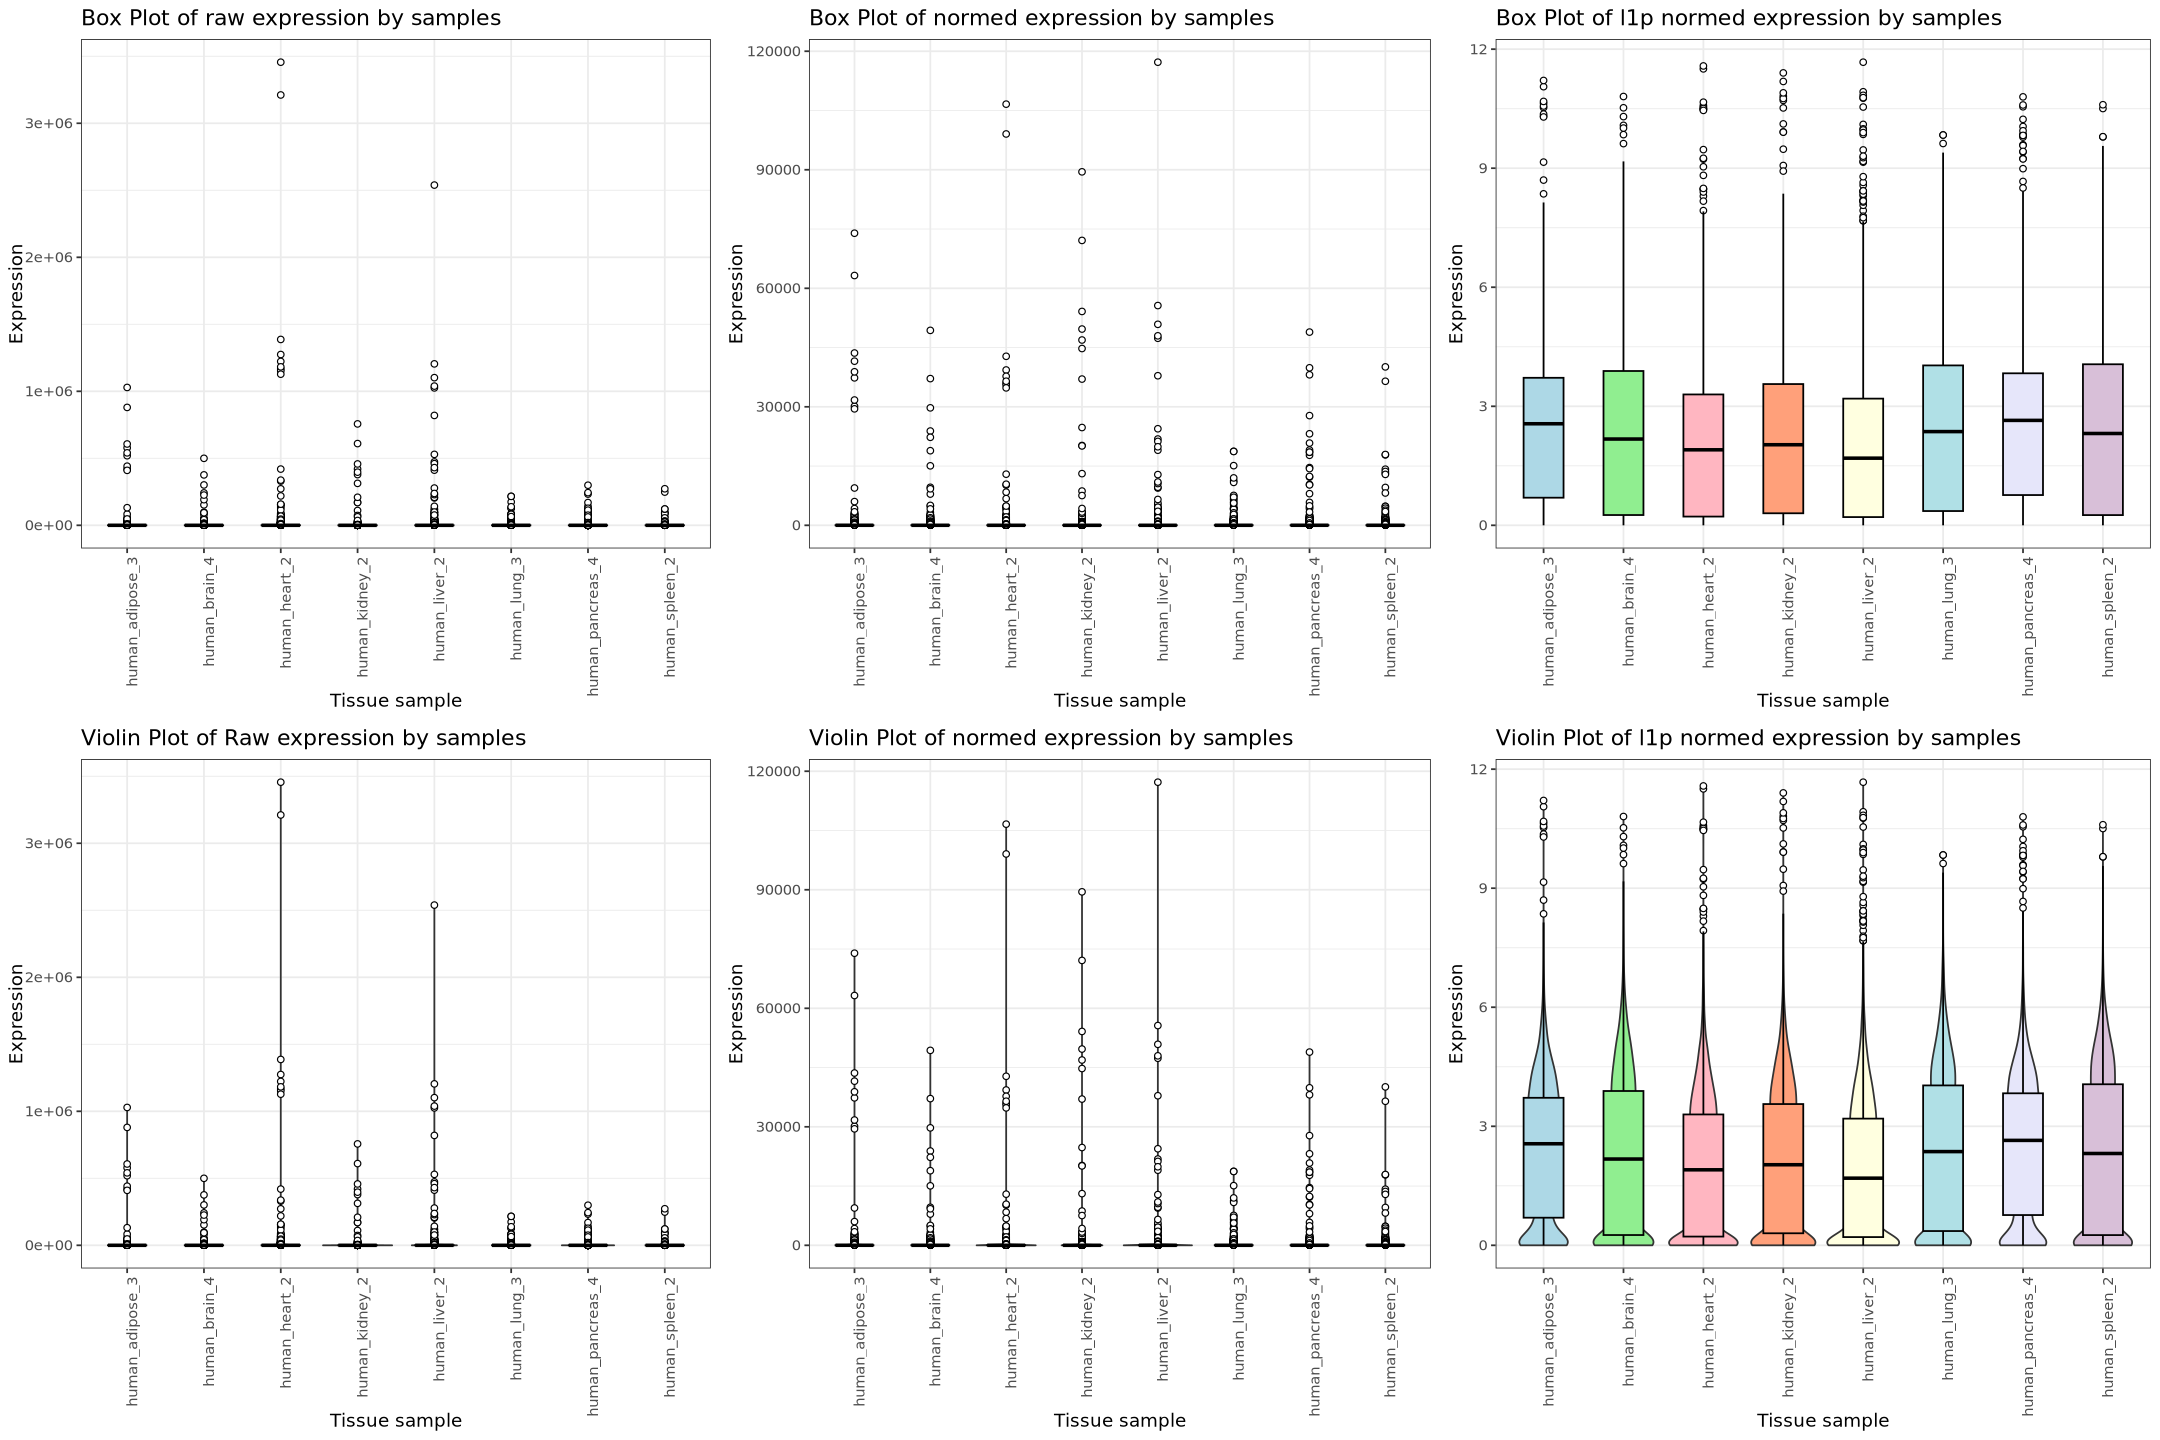

In [27]:
grid.arrange(boxplot_human, boxplot_normed_human, boxplot_log1p_normed_human, violinplot_human, 
    violinplot_normed_human, violinplot_log1p_normed_human,
    ncol = 3, nrow=2)

### Normalization and log transformation enhance the accuracy of fold change calculations.

In [28]:
ref <- "human_brain_4"

l1p_normed_human <- log1p(normed_human)
a <- log1p_normed_human[dlx_rows,ref]

# Get all columns except reference
col_subset <- colnames(l1p_normed_human)[colnames(l1p_normed_human) != ref]
# Calculate fold changes
l1p_normed_human_fold_changes <- sapply(col_subset, function(c) {
    b <- l1p_normed_human[dlx_rows, c]
    (b - a) / a
})
l1p_normed_human_fold_changes[is.na(l1p_normed_human_fold_changes)] <- 0

inf_mask <- is.infinite(l1p_normed_human_fold_changes)
l1p_normed_human_fold_changes[inf_mask] <- l1p_normed_human[dlx_rows, col_subset][inf_mask]
l1p_normed_human_fold_changes


,human_adipose_3,human_heart_2,human_kidney_2,⋯,human_lung_3,human_pancreas_4,human_spleen_2
DLX4,0.4988791,0.0000000,0.0000000,⋯,0.9729179,0.2828972,0.4626388
DLX5,-0.8350029,-0.9836718,-1.0000000,⋯,-1.0000000,-1.0000000,-0.9262644
DLX3,0.3070248,0.0000000,0.1117536,⋯,0.1597578,0.6835544,0.0000000
DLX6,-0.9067220,-1.0000000,-1.0000000,⋯,-1.0000000,-1.0000000,-1.0000000
DLX1,-0.8894182,-0.9507072,-1.0000000,⋯,-1.0000000,-0.8753336,-1.0000000
DLX2,-0.7914173,-1.0000000,-1.0000000,⋯,-1.0000000,-1.0000000,-1.0000000


In [29]:
options(repr.plot.width = 6, repr.plot.height = 6)

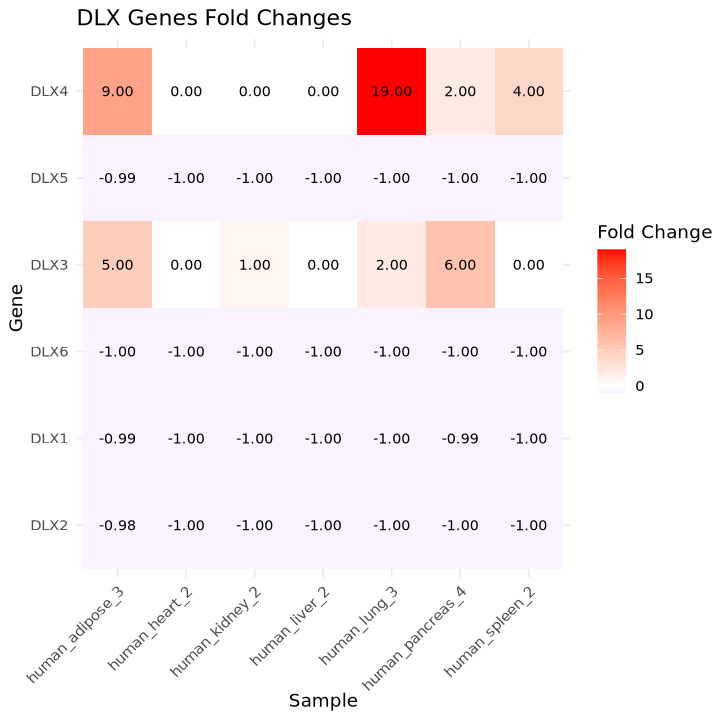

In [30]:
human_fold_changes_long <- as.data.frame(human_fold_changes) %>%
  rownames_to_column("Gene") %>%
  mutate(Gene = factor(Gene, levels = dlx_rows)) %>%  # Preserve original row order
  pivot_longer(-Gene, names_to = "Sample", values_to = "FoldChange")


ggplot(human_fold_changes_long, aes(x = Sample, y = Gene, fill = FoldChange)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  geom_text(aes(label = sprintf("%.2f", FoldChange)), size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_discrete(limits = rev) +
  labs(
    title = "DLX Genes Fold Changes",
    x = "Sample",
    y = "Gene",
    fill = "Fold Change"
  ) +
  theme()

In [31]:
options(repr.plot.width = 6, repr.plot.height = 6)

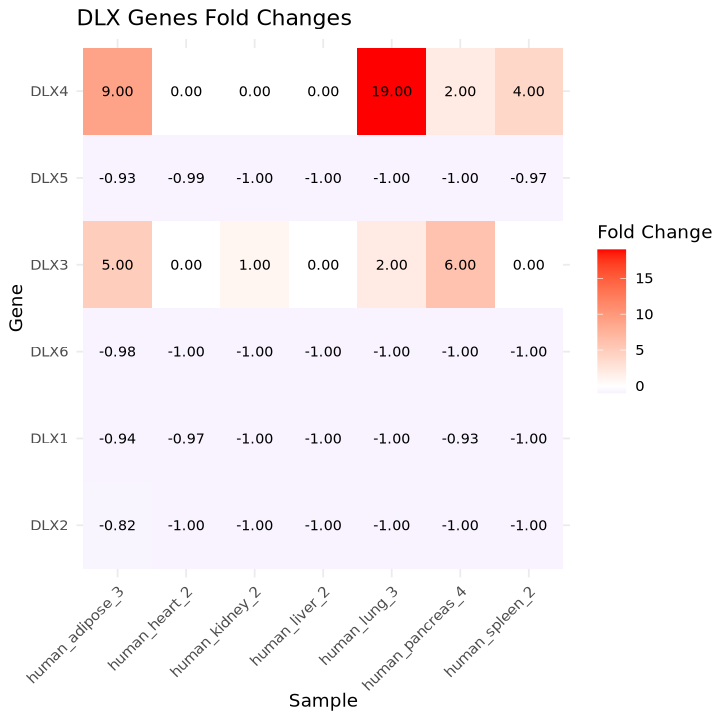

In [32]:
normed_human_fold_changes_long <- as.data.frame(normed_human_fold_changes) %>%
  rownames_to_column("Gene") %>%
  mutate(Gene = factor(Gene, levels = dlx_rows)) %>%  # Preserve original row order
  pivot_longer(-Gene, names_to = "Sample", values_to = "FoldChange")


ggplot(normed_human_fold_changes_long, aes(x = Sample, y = Gene, fill = FoldChange)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  geom_text(aes(label = sprintf("%.2f", FoldChange)), size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_discrete(limits = rev) +
  labs(
    title = "DLX Genes Fold Changes",
    x = "Sample",
    y = "Gene",
    fill = "Fold Change"
  ) +
  theme()

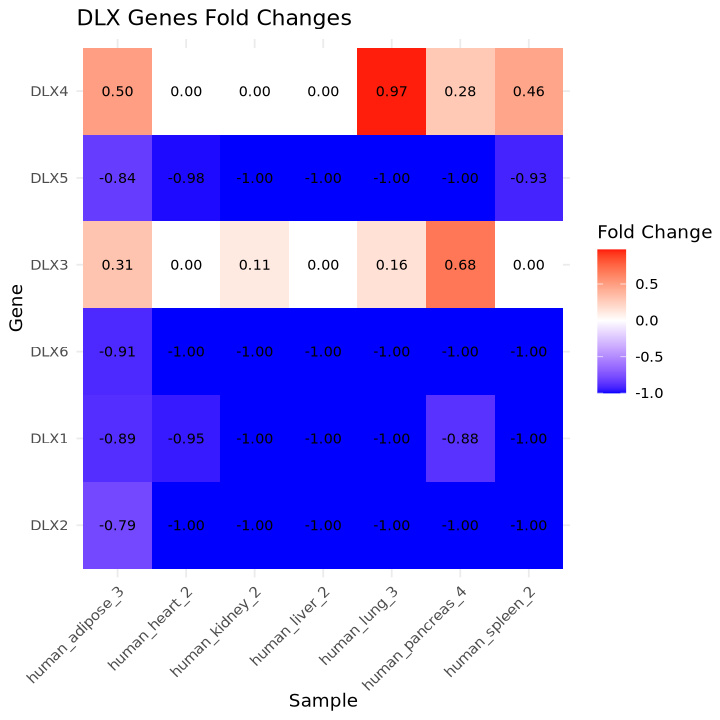

In [33]:
l1p_normed_human_fold_changes_long <- as.data.frame(l1p_normed_human_fold_changes) %>%
  rownames_to_column("Gene") %>%
  mutate(Gene = factor(Gene, levels = dlx_rows)) %>%  # Preserve original row order
  pivot_longer(-Gene, names_to = "Sample", values_to = "FoldChange")


ggplot(l1p_normed_human_fold_changes_long, aes(x = Sample, y = Gene, fill = FoldChange)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  geom_text(aes(label = sprintf("%.2f", FoldChange)), size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_discrete(limits = rev) +
  labs(
    title = "DLX Genes Fold Changes",
    x = "Sample",
    y = "Gene",
    fill = "Fold Change"
  ) +
  theme()

In [34]:
# Remove legends from plots
plot1 <- ggplot(human_fold_changes_long, aes(x = Sample, y = Gene, fill = FoldChange)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  geom_text(aes(label = sprintf("%.2f", FoldChange)), size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_discrete(limits = rev) +
  labs(
    title = "Raw FC",
    x = "Sample",
    y = "Gene",
    fill = "Fold Change"
  ) +
  theme(legend.position = "none")  # Remove legend

plot2 <- ggplot(normed_human_fold_changes_long, aes(x = Sample, y = Gene, fill = FoldChange)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  geom_text(aes(label = sprintf("%.2f", FoldChange)), size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_discrete(limits = rev) +
  labs(
    title = "Normed FC",
    x = "Sample",
    y = "Gene",
    fill = "Fold Change"
  ) +
  theme(legend.position = "none")  # Remove legend

plot3 <- ggplot(l1p_normed_human_fold_changes_long, aes(x = Sample, y = Gene, fill = FoldChange)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  geom_text(aes(label = sprintf("%.2f", FoldChange)), size = 3) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_discrete(limits = rev) +
  labs(
    title = "l1p Normed FC",
    x = "Sample",
    y = "Gene",
    fill = "Fold Change"
  ) +
  theme()  # Keep legend for this plot


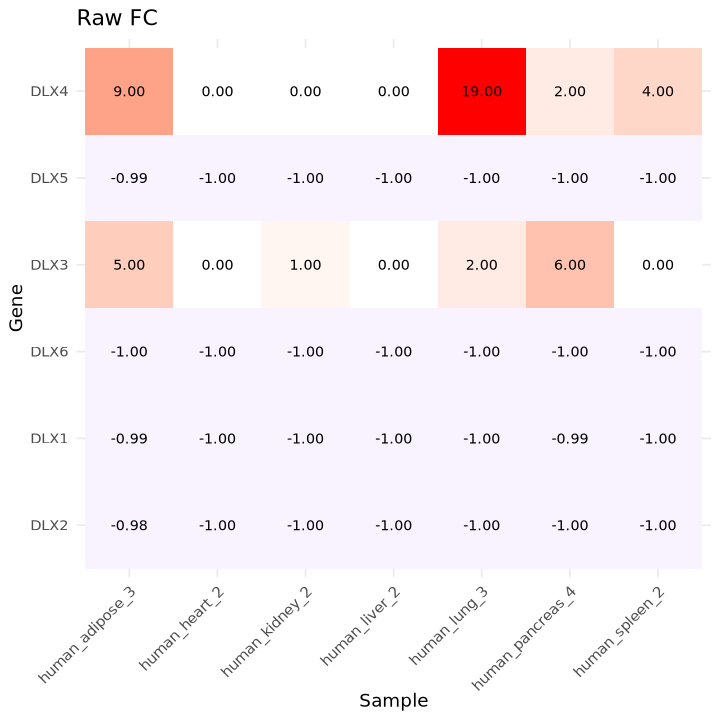

In [35]:
plot1

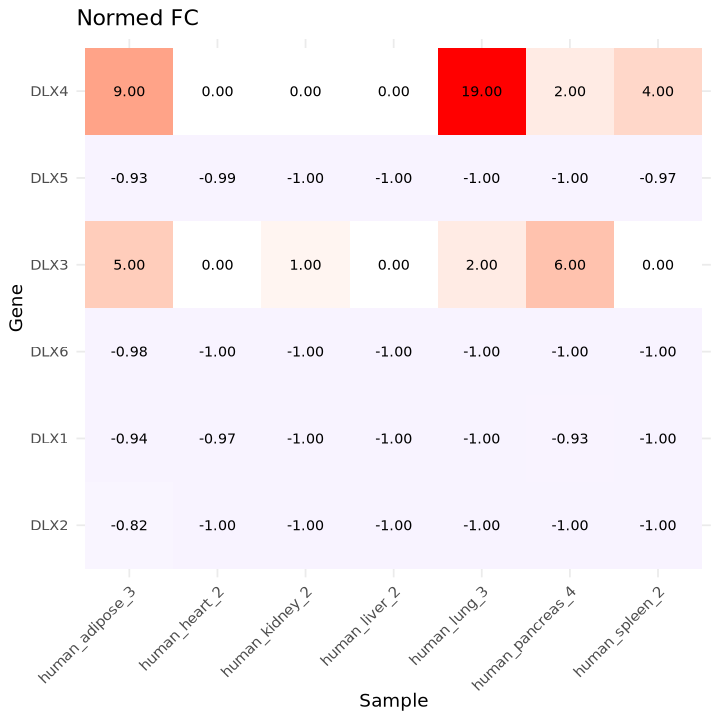

In [36]:
plot2

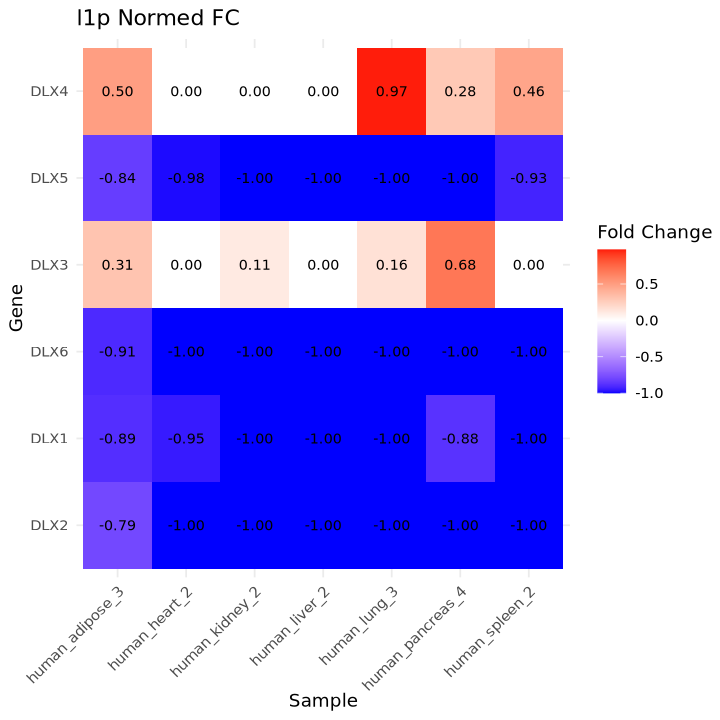

In [37]:
plot3

## 5. Merging data

In [38]:
mouse_brain_cols <- colnames(mouse)[grep("brain", colnames(mouse))]
mouse_brain_cols

[1] "mouse_brain_4"

In [39]:
mouse_dlx_rows <- rownames(mouse)[grep("DLX", toupper(rownames(mouse)))]
mouse_dlx_rows

[1] "Dlx4" "Dlx5" "Dlx3" "Dlx6" "Dlx1" "Dlx2"

In [40]:
mouse[mouse_dlx_rows,]

,mouse_adipose_1,mouse_brain_4,mouse_heart_5,⋯,mouse_lung_1,mouse_pancreas_1,mouse_spleen_4
,<int>,<int>,<int>,⋯,<int>,<int>,<int>
Dlx4,5,1,0,⋯,1,1,0
Dlx5,4,37,0,⋯,0,0,0
Dlx3,2,0,0,⋯,0,0,1
Dlx6,2,152,0,⋯,0,0,0
Dlx1,1,217,1,⋯,0,1,2
Dlx2,0,16,0,⋯,0,0,0


In [41]:
normed_mouse <- log1p(t(t(mouse) / colSums(mouse)) * 1e6)
normed_mouse[mouse_dlx_rows,]

,mouse_adipose_1,mouse_brain_4,mouse_heart_5,⋯,mouse_lung_1,mouse_pancreas_1,mouse_spleen_4
Dlx4,0.26803984,0.06739077,0.00000000,⋯,0.07359383,0.2179555,0.00000000
Dlx5,0.21987372,1.27519409,0.00000000,⋯,0.00000000,0.0000000,0.00000000
Dlx3,0.11596778,0.00000000,0.00000000,⋯,0.00000000,0.0000000,0.04632666
Dlx6,0.11596778,2.45069798,0.00000000,⋯,0.00000000,0.0000000,0.00000000
Dlx1,0.05966402,2.78054508,0.05694657,⋯,0.00000000,0.2179555,0.09060185
Dlx2,0.00000000,0.74925078,0.00000000,⋯,0.00000000,0.0000000,0.00000000


In [42]:
gene_map[gene_map$mouse %in%  mouse_dlx_rows,]

,human,mouse
,<chr>,<chr>
Dlx4_DLX4,DLX4,Dlx4
Dlx5_DLX5,DLX5,Dlx5
Dlx3_DLX3,DLX3,Dlx3
Dlx6_DLX6,DLX6,Dlx6
Dlx1_DLX1,DLX1,Dlx1
Dlx2_DLX2,DLX2,Dlx2


In [43]:
normed_mouse[gene_map[gene_map$mouse %in%  mouse_dlx_rows,]$mouse, ]

,mouse_adipose_1,mouse_brain_4,mouse_heart_5,⋯,mouse_lung_1,mouse_pancreas_1,mouse_spleen_4
Dlx4,0.26803984,0.06739077,0.00000000,⋯,0.07359383,0.2179555,0.00000000
Dlx5,0.21987372,1.27519409,0.00000000,⋯,0.00000000,0.0000000,0.00000000
Dlx3,0.11596778,0.00000000,0.00000000,⋯,0.00000000,0.0000000,0.04632666
Dlx6,0.11596778,2.45069798,0.00000000,⋯,0.00000000,0.0000000,0.00000000
Dlx1,0.05966402,2.78054508,0.05694657,⋯,0.00000000,0.2179555,0.09060185
Dlx2,0.00000000,0.74925078,0.00000000,⋯,0.00000000,0.0000000,0.00000000


In [44]:
mouse_with_genes <- as.data.frame(normed_mouse)
mouse_with_genes$mouse <- rownames(mouse_with_genes)
mouse_with_genes

,mouse_adipose_1,mouse_brain_4,mouse_heart_5,⋯,mouse_pancreas_1,mouse_spleen_4,mouse
,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>
Stag2,5.294056,5.525978,4.6568766,⋯,4.589170,6.19751029,Stag2
Stag1,5.136208,4.611356,3.8976356,⋯,3.747158,5.33283822,Stag1
Gosr2,4.598209,3.892484,2.7836031,⋯,3.866149,5.15755034,Gosr2
4933434E20Rik,3.793347,3.883917,3.0153560,⋯,2.906396,4.56557153,4933434E20Rik
Art5,0.000000,0.000000,0.2569622,⋯,0.000000,0.09060185,Art5
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
Fam83e,0.7154747,0.0000000,0.0000000,⋯,0.000000,0.1736726,Fam83e
Fam83b,1.5837570,0.1305253,0.1619468,⋯,0.796452,0.1736726,Fam83b
Fam83f,1.2759642,0.1305253,0.0000000,⋯,1.160581,1.0957727,Fam83f


In [45]:
gene_map[gene_map$mouse %in%  mouse_dlx_rows,]

,human,mouse
,<chr>,<chr>
Dlx4_DLX4,DLX4,Dlx4
Dlx5_DLX5,DLX5,Dlx5
Dlx3_DLX3,DLX3,Dlx3
Dlx6_DLX6,DLX6,Dlx6
Dlx1_DLX1,DLX1,Dlx1
Dlx2_DLX2,DLX2,Dlx2


In [46]:
t <- gene_map %>%
  filter(mouse %in% mouse_dlx_rows) %>%
  left_join(mouse_with_genes, by = "mouse")
t

human,mouse,mouse_adipose_1,⋯,mouse_lung_1,mouse_pancreas_1,mouse_spleen_4
<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>
DLX4,Dlx4,0.26803984,⋯,0.07359383,0.2179555,0.00000000
DLX5,Dlx5,0.21987372,⋯,0.00000000,0.0000000,0.00000000
DLX3,Dlx3,0.11596778,⋯,0.00000000,0.0000000,0.04632666
DLX6,Dlx6,0.11596778,⋯,0.00000000,0.0000000,0.00000000
DLX1,Dlx1,0.05966402,⋯,0.00000000,0.2179555,0.09060185
DLX2,Dlx2,0.00000000,⋯,0.00000000,0.0000000,0.00000000


In [47]:
rownames(t)<-rownames(gene_map[gene_map$mouse %in%  mouse_dlx_rows,])
t

,human,mouse,mouse_adipose_1,⋯,mouse_lung_1,mouse_pancreas_1,mouse_spleen_4
,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>
Dlx4_DLX4,DLX4,Dlx4,0.26803984,⋯,0.07359383,0.2179555,0.00000000
Dlx5_DLX5,DLX5,Dlx5,0.21987372,⋯,0.00000000,0.0000000,0.00000000
Dlx3_DLX3,DLX3,Dlx3,0.11596778,⋯,0.00000000,0.0000000,0.04632666
Dlx6_DLX6,DLX6,Dlx6,0.11596778,⋯,0.00000000,0.0000000,0.00000000
Dlx1_DLX1,DLX1,Dlx1,0.05966402,⋯,0.00000000,0.2179555,0.09060185
Dlx2_DLX2,DLX2,Dlx2,0.00000000,⋯,0.00000000,0.0000000,0.00000000


In [48]:
normed_human_with_genes <- as.data.frame(log1p(normed_human))
normed_human_with_genes$human <- rownames(normed_human_with_genes)
normed_human_with_genes

,human_adipose_3,human_brain_4,human_heart_2,⋯,human_pancreas_4,human_spleen_2,human
,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>
STAG2,4.64228428,5.517641,3.9980787,⋯,4.5590630,5.882790,STAG2
STAG1,4.11112895,4.559753,3.6356651,⋯,4.3051120,4.759950,STAG1
GOSR2,2.41647071,1.599028,1.9123372,⋯,2.7751206,2.254420,GOSR2
C1orf43,4.90081939,5.757206,5.0125110,⋯,5.2682448,5.301149,C1orf43
ART5,0.06940938,0.000000,0.4216302,⋯,0.1514193,0.000000,ART5
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
FAM83E,0.06940938,0.0000000,0.00000000,⋯,0.1514193,0.0000000,FAM83E
FAM83B,0.19525816,0.0000000,0.11635868,⋯,1.2852992,0.0000000,FAM83B
FAM83F,0.49887914,0.2593725,0.08851355,⋯,0.7628554,0.0000000,FAM83F


In [49]:
star_normed_mouse = gene_map %>% left_join(mouse_with_genes, by = "mouse")
rownames(star_normed_mouse) <- rownames(gene_map)
star_normed_human = gene_map %>% left_join(normed_human_with_genes, by = "human")
rownames(star_normed_human) <- rownames(star_normed_human)
star_normed_human

,human,mouse,human_adipose_3,⋯,human_lung_3,human_pancreas_4,human_spleen_2
,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>
1,STAG2,Stag2,4.64228428,⋯,5.7702040,4.5590630,5.882790
2,STAG1,Stag1,4.11112895,⋯,4.3522474,4.3051120,4.759950
3,GOSR2,Gosr2,2.41647071,⋯,1.8651089,2.7751206,2.254420
4,C1orf43,4933434E20Rik,4.90081939,⋯,6.0001568,5.2682448,5.301149
5,ART5,Art5,0.06940938,⋯,0.4184997,0.1514193,0.000000
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
14740,FAM83E,Fam83e,0.06940938,⋯,0.2974739,0.1514193,0.0000000
14741,FAM83B,Fam83b,0.19525816,⋯,0.2974739,1.2852992,0.0000000
14742,FAM83F,Fam83f,0.49887914,⋯,0.0000000,0.7628554,0.0000000


In [50]:
star_normed_human

,human,mouse,human_adipose_3,⋯,human_lung_3,human_pancreas_4,human_spleen_2
,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>
1,STAG2,Stag2,4.64228428,⋯,5.7702040,4.5590630,5.882790
2,STAG1,Stag1,4.11112895,⋯,4.3522474,4.3051120,4.759950
3,GOSR2,Gosr2,2.41647071,⋯,1.8651089,2.7751206,2.254420
4,C1orf43,4933434E20Rik,4.90081939,⋯,6.0001568,5.2682448,5.301149
5,ART5,Art5,0.06940938,⋯,0.4184997,0.1514193,0.000000
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
14740,FAM83E,Fam83e,0.06940938,⋯,0.2974739,0.1514193,0.0000000
14741,FAM83B,Fam83b,0.19525816,⋯,0.2974739,1.2852992,0.0000000
14742,FAM83F,Fam83f,0.49887914,⋯,0.0000000,0.7628554,0.0000000


In [51]:
 star_normed_mouse %>% left_join(star_normed_human, by = "mouse") 

human.x,mouse,mouse_adipose_1,⋯,human_lung_3,human_pancreas_4,human_spleen_2
<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>
STAG2,Stag2,5.294056,⋯,5.7702040,4.5590630,5.882790
STAG1,Stag1,5.136208,⋯,4.3522474,4.3051120,4.759950
GOSR2,Gosr2,4.598209,⋯,1.8651089,2.7751206,2.254420
C1orf43,4933434E20Rik,3.793347,⋯,6.0001568,5.2682448,5.301149
ART5,Art5,0.000000,⋯,0.4184997,0.1514193,0.000000
⋮,⋮,⋮,⋱,⋮,⋮,⋮
FAM83E,Fam83e,0.7154747,⋯,0.2974739,0.1514193,0.0000000
FAM83B,Fam83b,1.5837570,⋯,0.2974739,1.2852992,0.0000000
FAM83F,Fam83f,1.2759642,⋯,0.0000000,0.7628554,0.0000000


In [52]:
merged_df <- star_normed_mouse %>% left_join(star_normed_human, by = "mouse")  %>% select (-human.x, -mouse, -human.y)
rownames(merged_df) <- rownames(star_normed_mouse)
merged_df

,mouse_adipose_1,mouse_brain_4,mouse_heart_5,⋯,human_lung_3,human_pancreas_4,human_spleen_2
,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>
Stag2_STAG2,5.294056,5.525978,4.6568766,⋯,5.7702040,4.5590630,5.882790
Stag1_STAG1,5.136208,4.611356,3.8976356,⋯,4.3522474,4.3051120,4.759950
Gosr2_GOSR2,4.598209,3.892484,2.7836031,⋯,1.8651089,2.7751206,2.254420
4933434E20Rik_C1orf43,3.793347,3.883917,3.0153560,⋯,6.0001568,5.2682448,5.301149
Art5_ART5,0.000000,0.000000,0.2569622,⋯,0.4184997,0.1514193,0.000000
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
Fam83e_FAM83E,0.7154747,0.0000000,0.0000000,⋯,0.2974739,0.1514193,0.0000000
Fam83b_FAM83B,1.5837570,0.1305253,0.1619468,⋯,0.2974739,1.2852992,0.0000000
Fam83f_FAM83F,1.2759642,0.1305253,0.0000000,⋯,0.0000000,0.7628554,0.0000000


In [53]:
# Compute correlation matrix for all columns
cor_matrix <- cor(merged_df, use = "pairwise.complete.obs", method = "pearson")

cor_matrix

,mouse_adipose_1,mouse_brain_4,mouse_heart_5,⋯,human_lung_3,human_pancreas_4,human_spleen_2
mouse_adipose_1,1.0000000,0.6994858,0.7883133,⋯,0.7423380,0.7134749,0.7231739
mouse_brain_4,0.6994858,1.0000000,0.7435032,⋯,0.6264942,0.5954921,0.6419058
mouse_heart_5,0.7883133,0.7435032,1.0000000,⋯,0.7133412,0.6538402,0.7169346
mouse_kidney_5,0.8226993,0.7236084,0.8198354,⋯,0.7324964,0.6920908,0.7121871
mouse_liver_5,0.7402574,0.6126792,0.7480936,⋯,0.6697051,0.6585502,0.6567237
⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮
human_kidney_2,0.7335997,0.6511392,0.7193126,⋯,0.8672564,0.8143079,0.8278600
human_liver_2,0.6701318,0.5338593,0.6452667,⋯,0.7517956,0.7861193,0.7441859
human_lung_3,0.7423380,0.6264942,0.7133412,⋯,1.0000000,0.8078109,0.8979468
human_pancreas_4,0.7134749,0.5954921,0.6538402,⋯,0.8078109,1.0000000,0.8035851


In [54]:
options(repr.plot.width = 12, repr.plot.height = 12)

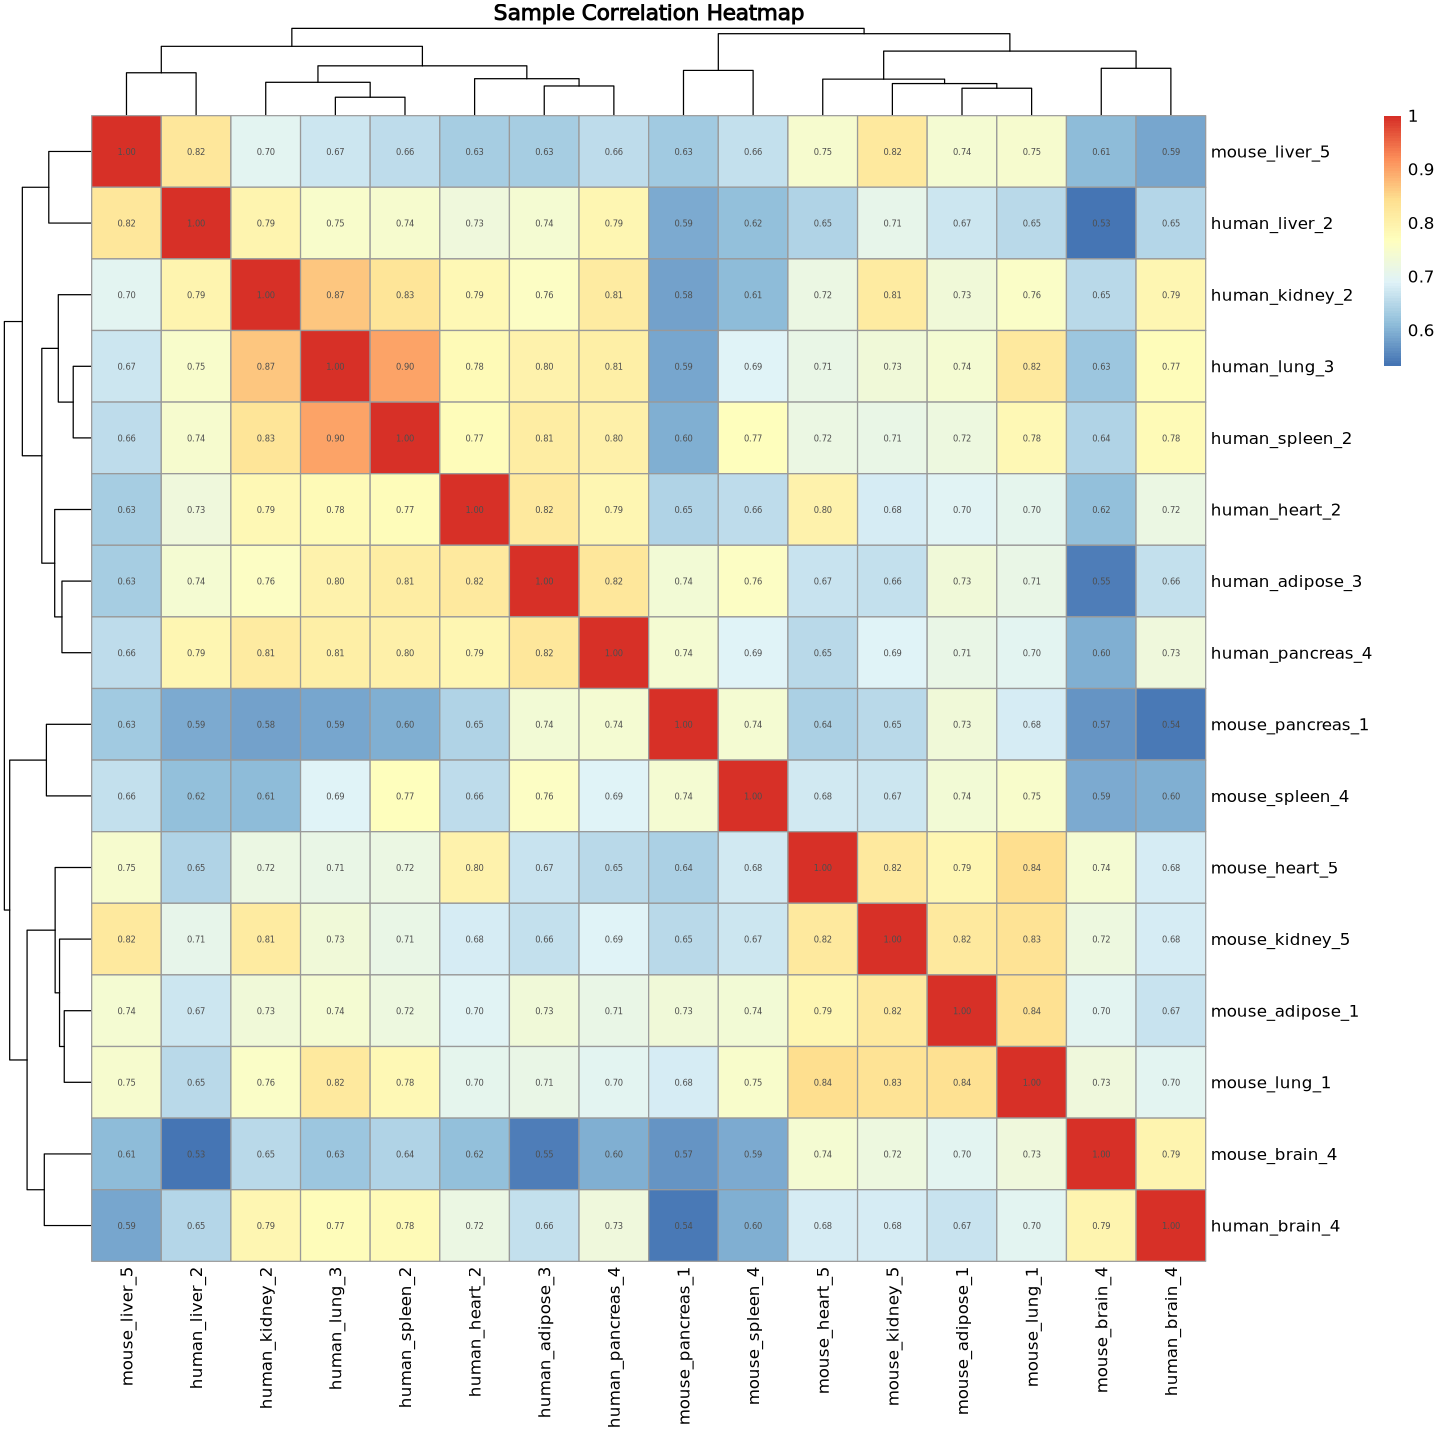

In [55]:
# Create clustered heatmap with dendrograms
library(pheatmap)
pheatmap(cor_matrix,
         display_numbers = TRUE,
         number_format = "%.2f",
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         clustering_distance_rows = "euclidean",
         clustering_method = "complete",
         # color = colorRampPalette(c("blue", "white", "red"))(100),
         fontsize_number = 5,  # Adjust number size
         angle_col = 90,       # Rotate column labels
         main = "Sample Correlation Heatmap")  # Add title


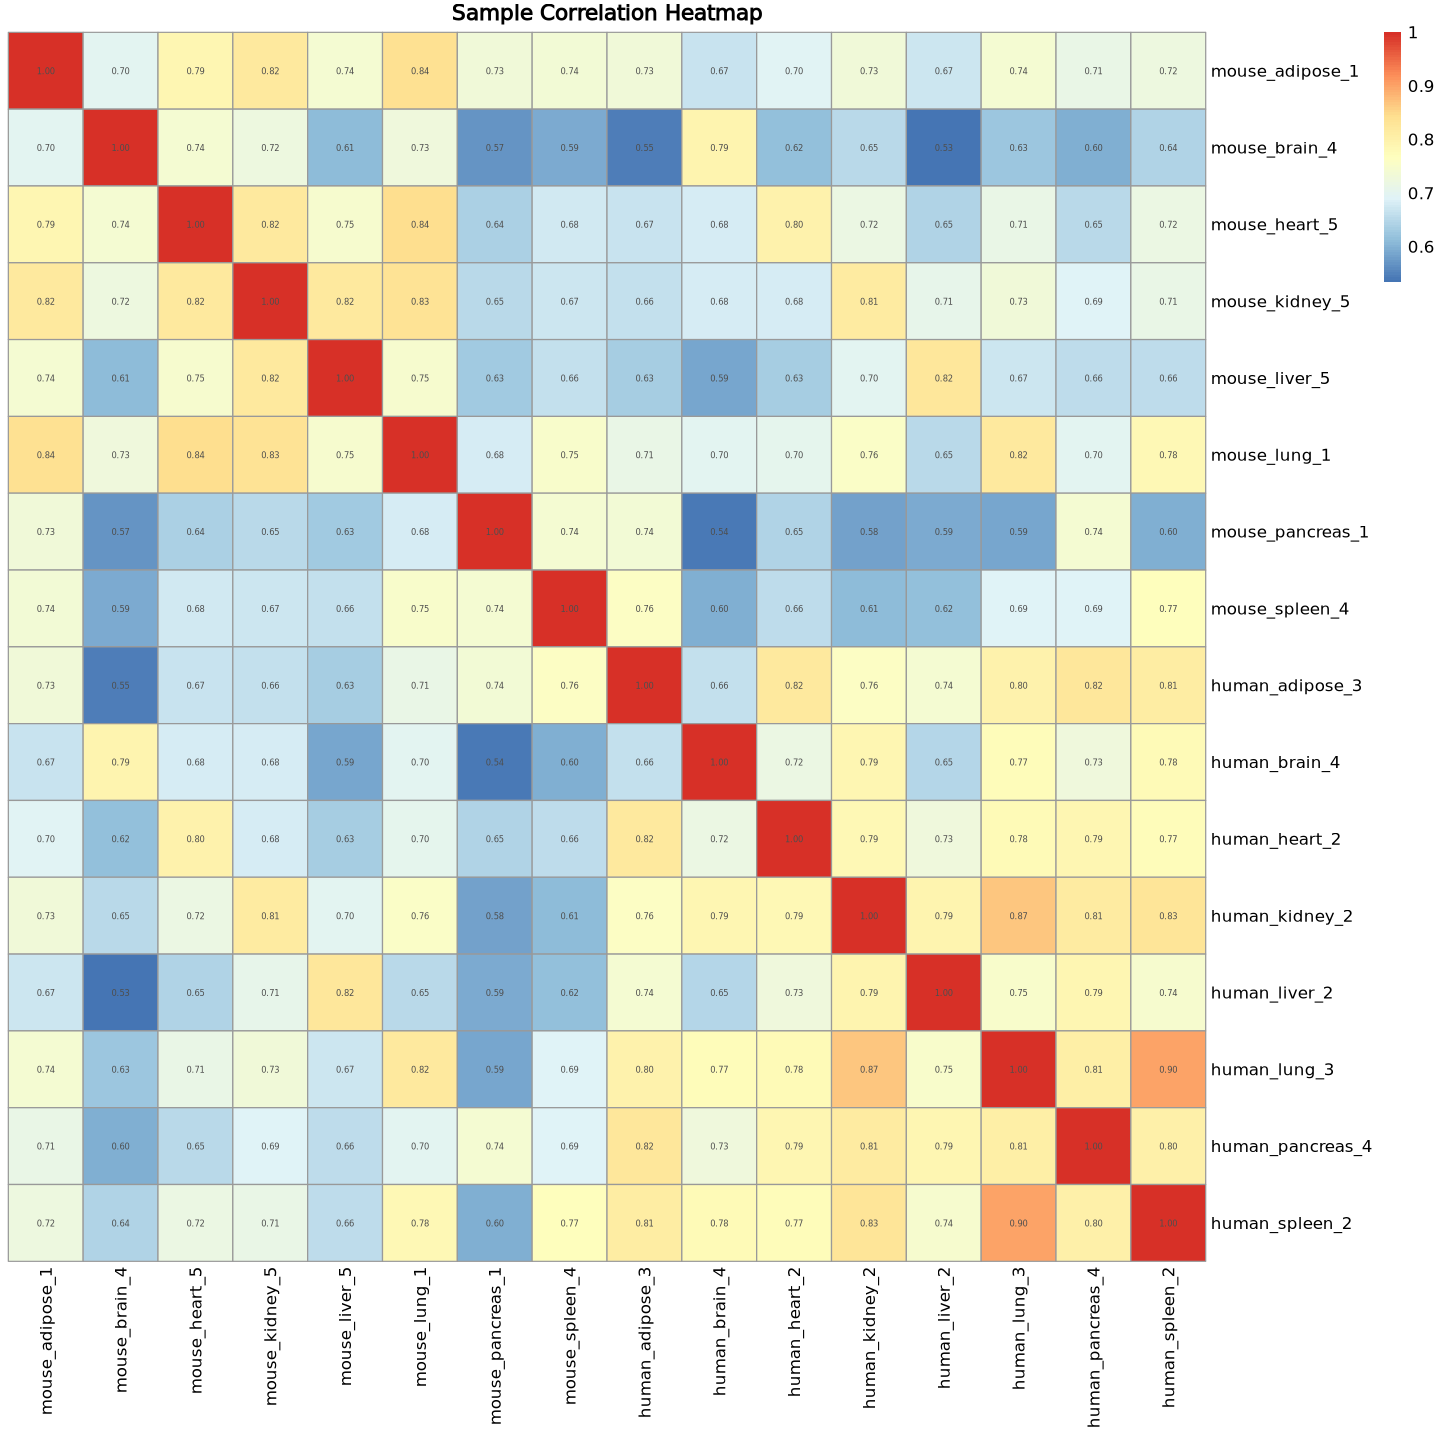

In [56]:
# Create clustered heatmap with dendrograms
library(pheatmap)
pheatmap(cor_matrix,
         display_numbers = TRUE,
         number_format = "%.2f",
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         #clustering_distance_rows = "euclidean",
         #clustering_method = "complete",
         #color = colorRampPalette(c("white", "blue"))(100),
         fontsize_number = 5,  # Adjust number size
         angle_col = 90,       # Rotate column labels
         main = "Sample Correlation Heatmap")  # Add title


In [57]:

# Convert the correlation matrix to long format
cor_long <- melt(cor_matrix)
cor_long

Var1,Var2,value
<fct>,<fct>,<dbl>
mouse_adipose_1,mouse_adipose_1,1.0000000
mouse_brain_4,mouse_adipose_1,0.6994858
mouse_heart_5,mouse_adipose_1,0.7883133
mouse_kidney_5,mouse_adipose_1,0.8226993
mouse_liver_5,mouse_adipose_1,0.7402574
⋮,⋮,⋮
human_kidney_2,human_spleen_2,0.8278600
human_liver_2,human_spleen_2,0.7441859
human_lung_3,human_spleen_2,0.8979468


Var1,Var2,value
<fct>,<fct>,<dbl>
mouse_adipose_1,mouse_adipose_1,1.0000000
mouse_brain_4,mouse_adipose_1,0.6994858
mouse_heart_5,mouse_adipose_1,0.7883133
mouse_kidney_5,mouse_adipose_1,0.8226993
mouse_liver_5,mouse_adipose_1,0.7402574
⋮,⋮,⋮
human_kidney_2,human_spleen_2,0.8278600
human_liver_2,human_spleen_2,0.7441859
human_lung_3,human_spleen_2,0.8979468


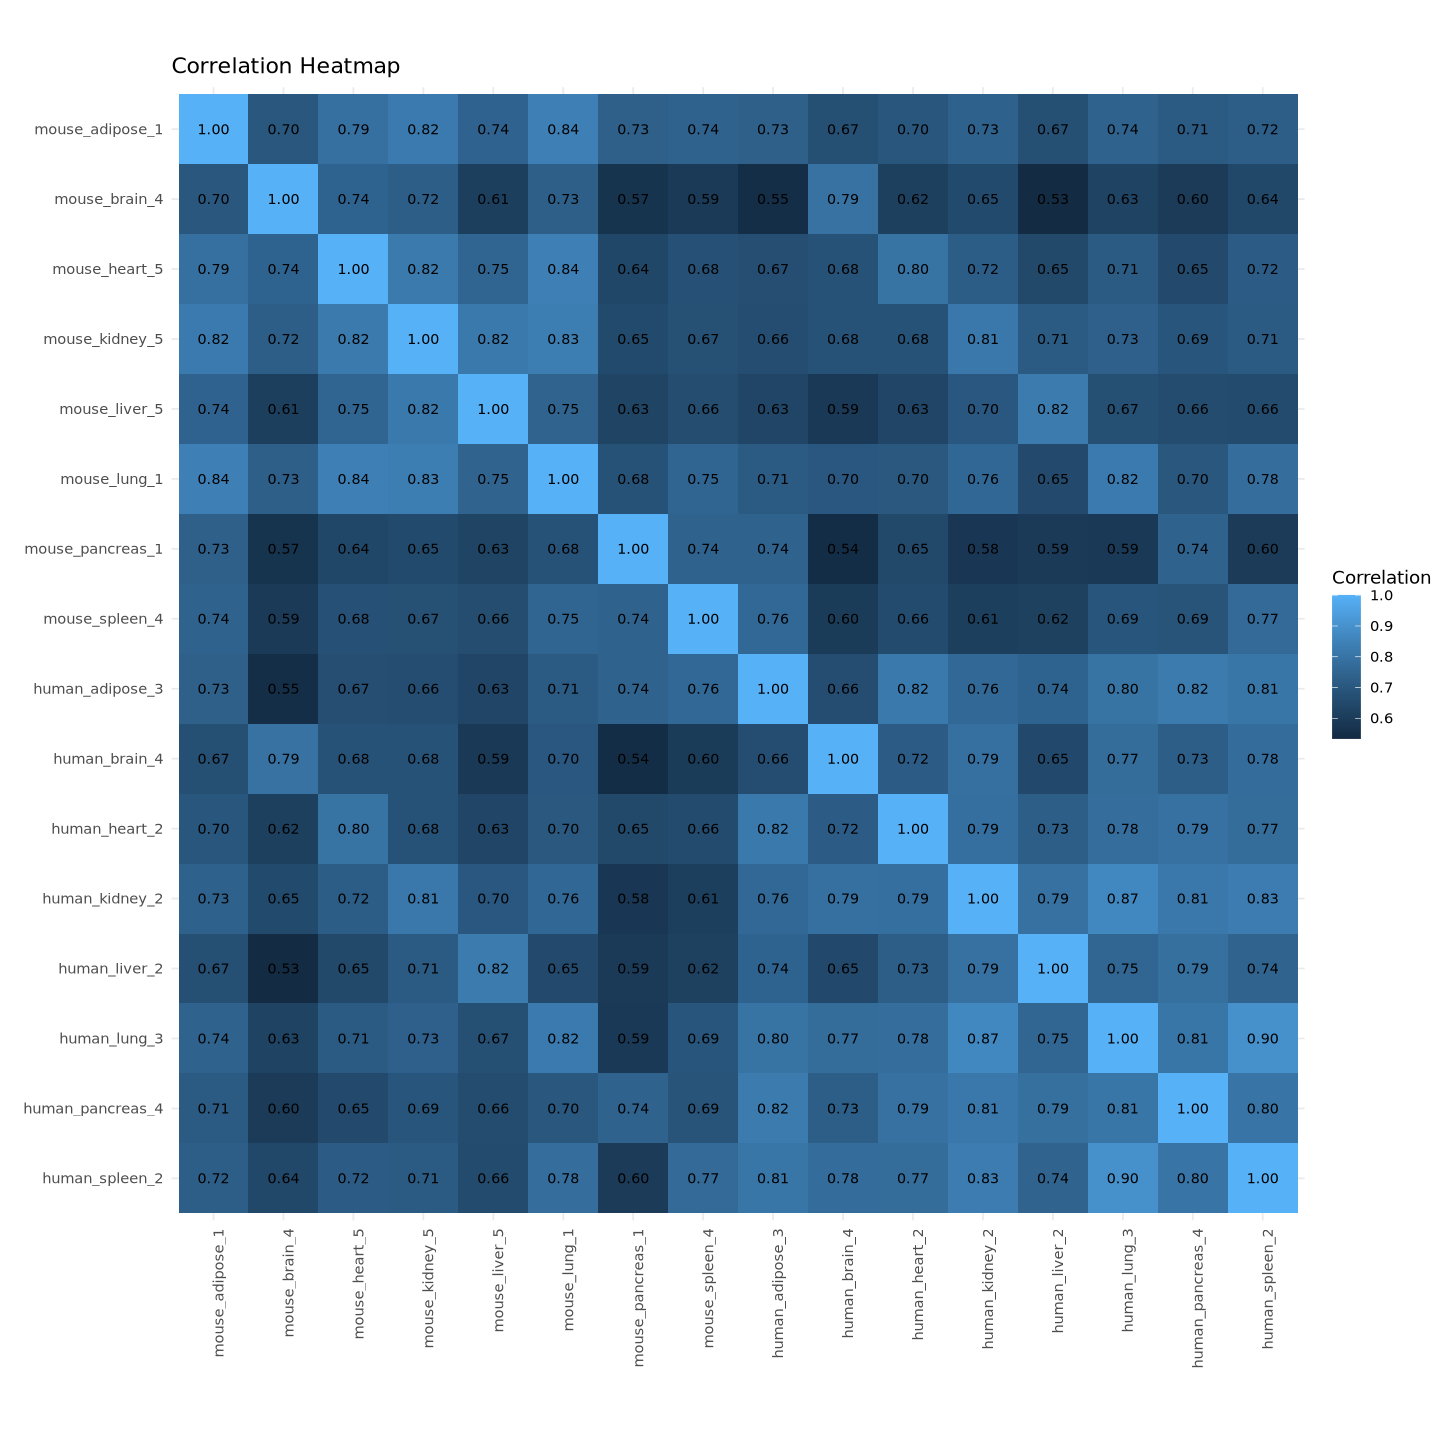

In [58]:
cor_long <- melt(cor_matrix)
cor_long
ggplot(cor_long, aes(x = Var2, y = Var1, fill = value)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f", value)), size = 3) +
  # scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Correlation Heatmap",
       x = "", y = "", fill = "Correlation") +
  coord_fixed() +
  scale_y_discrete(limits = rev)

In [59]:
options(repr.plot.width = 12, repr.plot.height = 12)

In [60]:
# Identify human and mouse columns
mouse_columns <- grep("^mouse_", colnames(merged_df), value = TRUE)
human_columns <- grep("^human_", colnames(merged_df), value = TRUE)

# Subset human and mouse data
mouse_data <- merged_df[, mouse_columns]
human_data <- merged_df[, human_columns]

# Compute correlation matrix
cor_matrix <- cor(mouse_data, human_data, use = "pairwise.complete.obs", method = "pearson")

# View correlation matrix
cor_matrix

,human_adipose_3,human_brain_4,human_heart_2,⋯,human_lung_3,human_pancreas_4,human_spleen_2
mouse_adipose_1,0.7316326,0.6690340,0.6966211,⋯,0.7423380,0.7134749,0.7231739
mouse_brain_4,0.5453512,0.7927934,0.6153052,⋯,0.6264942,0.5954921,0.6419058
mouse_heart_5,0.6669374,0.6812299,0.7958599,⋯,0.7133412,0.6538402,0.7169346
mouse_kidney_5,0.6632780,0.6807141,0.6799201,⋯,0.7324964,0.6920908,0.7121871
mouse_liver_5,0.6341172,0.5876701,0.6334096,⋯,0.6697051,0.6585502,0.6567237
mouse_lung_1,0.7112838,0.7005181,0.7026453,⋯,0.8226709,0.6987515,0.7811481
mouse_pancreas_1,0.7380145,0.5420394,0.6454866,⋯,0.5889416,0.7398120,0.5968758
mouse_spleen_4,0.7611797,0.5987089,0.6559650,⋯,0.6914659,0.6894500,0.7678320


,human_adipose_3,human_brain_4,human_heart_2,⋯,human_lung_3,human_pancreas_4,human_spleen_2
mouse_adipose_1,0.7316326,0.6690340,0.6966211,⋯,0.7423380,0.7134749,0.7231739
mouse_brain_4,0.5453512,0.7927934,0.6153052,⋯,0.6264942,0.5954921,0.6419058
mouse_heart_5,0.6669374,0.6812299,0.7958599,⋯,0.7133412,0.6538402,0.7169346
mouse_kidney_5,0.6632780,0.6807141,0.6799201,⋯,0.7324964,0.6920908,0.7121871
mouse_liver_5,0.6341172,0.5876701,0.6334096,⋯,0.6697051,0.6585502,0.6567237
mouse_lung_1,0.7112838,0.7005181,0.7026453,⋯,0.8226709,0.6987515,0.7811481
mouse_pancreas_1,0.7380145,0.5420394,0.6454866,⋯,0.5889416,0.7398120,0.5968758
mouse_spleen_4,0.7611797,0.5987089,0.6559650,⋯,0.6914659,0.6894500,0.7678320


Var1,Var2,value
<fct>,<fct>,<dbl>
mouse_adipose_1,human_adipose_3,0.7316326
mouse_brain_4,human_adipose_3,0.5453512
mouse_heart_5,human_adipose_3,0.6669374
mouse_kidney_5,human_adipose_3,0.6632780
mouse_liver_5,human_adipose_3,0.6341172
⋮,⋮,⋮
mouse_kidney_5,human_spleen_2,0.7121871
mouse_liver_5,human_spleen_2,0.6567237
mouse_lung_1,human_spleen_2,0.7811481


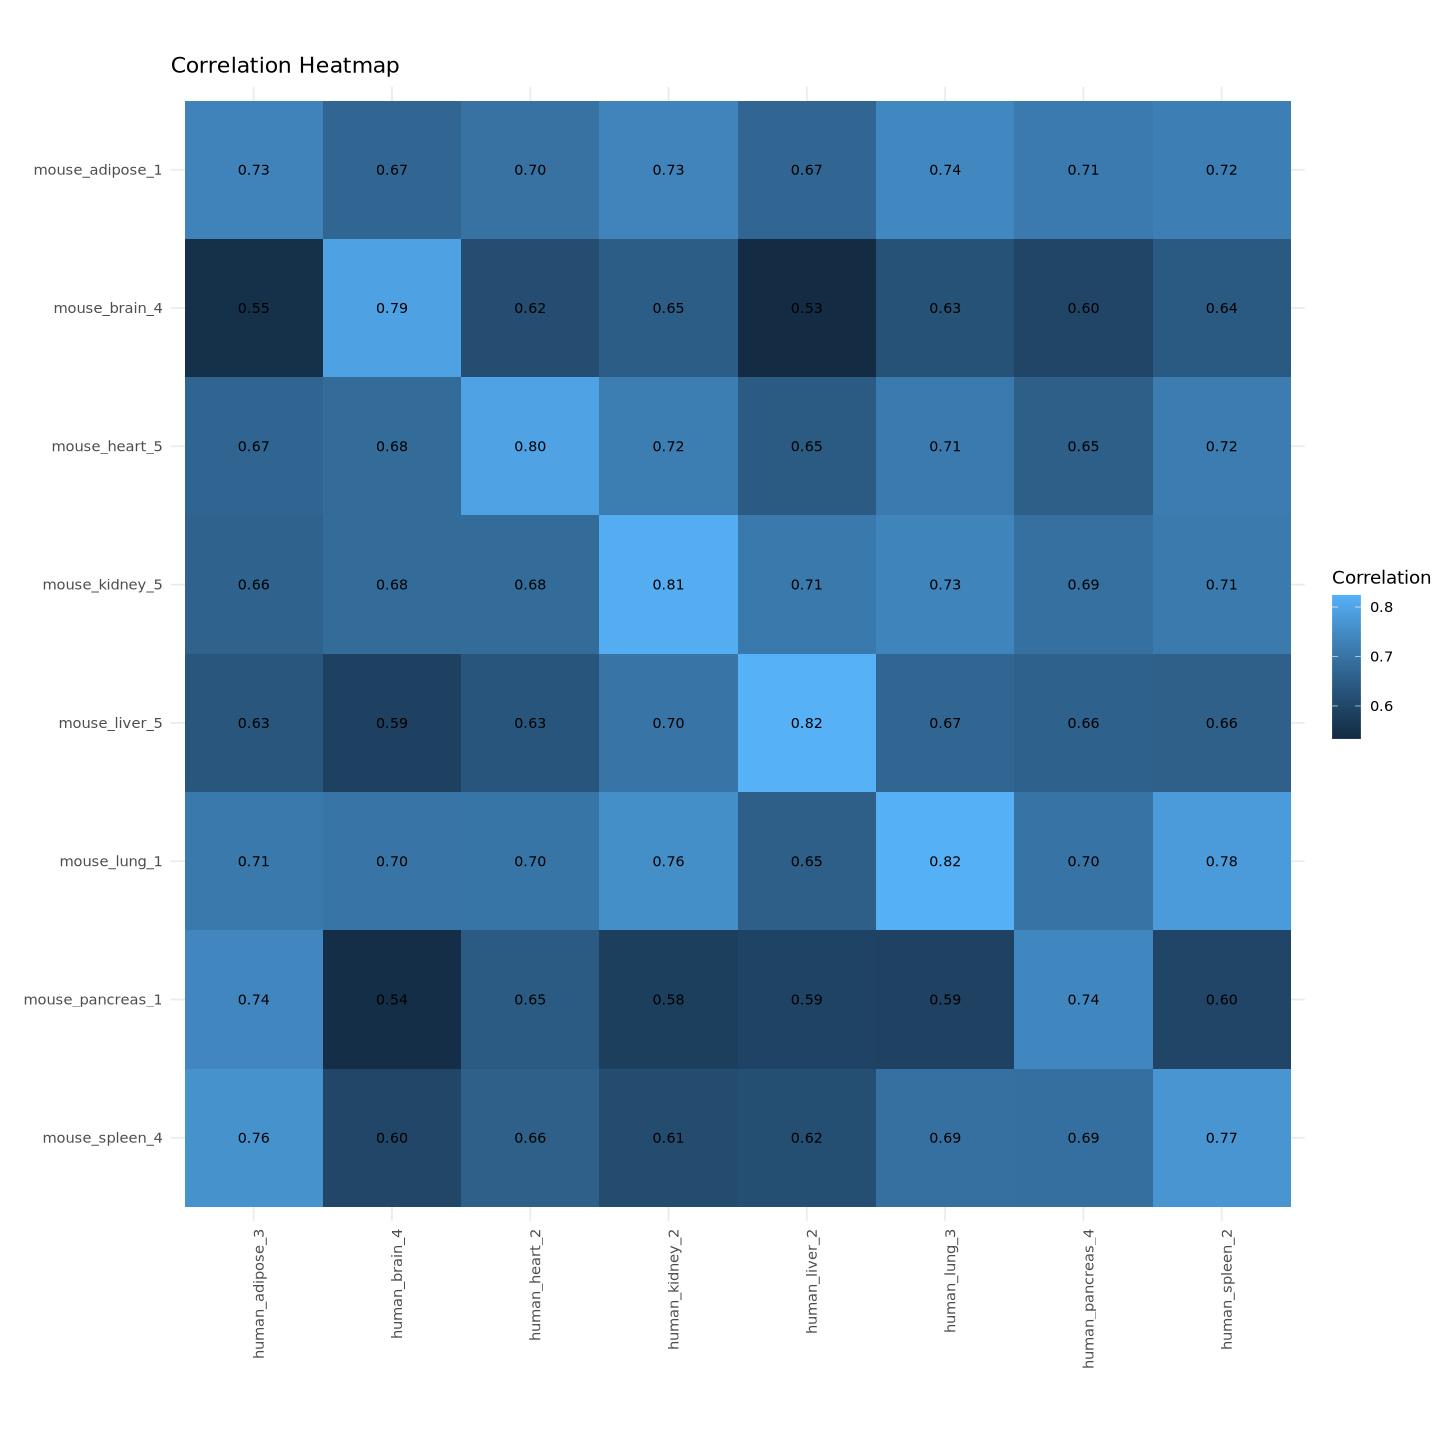

In [61]:
# Compute correlation matrix
cor_matrix <- cor(mouse_data, human_data, use = "pairwise.complete.obs", method = "pearson")

# View correlation matrix
cor_matrix

cor_long <- melt(cor_matrix)
cor_long
ggplot(cor_long, aes(x = Var2, y = Var1, fill = value)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f", value)), size = 3) +
  # scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Correlation Heatmap",
       x = "", y = "", fill = "Correlation") +
  coord_fixed() +
  scale_y_discrete(limits = rev)

In [64]:
##
### replacing metl with pivot_longer

In [63]:
# Convert the correlation matrix to a data frame
cor_df <- as.data.frame(cor_matrix)

# Optional: Add row names as a column (if needed)
cor_df <- rownames_to_column(cor_df, var = "Var1")

# Pivot the data frame to long format
long_data <- pivot_longer(
  cor_df, 
  cols = -Var1,  # Exclude the row names column
  names_to = "Var2", 
  values_to = "value"
)

# View the result
print(long_data)

# A tibble: 64 × 3
   Var1            Var2             value
   <chr>           <chr>            <dbl>
 1 mouse_adipose_1 human_adipose_3  0.732
 2 mouse_adipose_1 human_brain_4    0.669
 3 mouse_adipose_1 human_heart_2    0.697
 4 mouse_adipose_1 human_kidney_2   0.734
 5 mouse_adipose_1 human_liver_2    0.670
 6 mouse_adipose_1 human_lung_3     0.742
 7 mouse_adipose_1 human_pancreas_4 0.713
 8 mouse_adipose_1 human_spleen_2   0.723
 9 mouse_brain_4   human_adipose_3  0.545
10 mouse_brain_4   human_brain_4    0.793
# ℹ 54 more rows


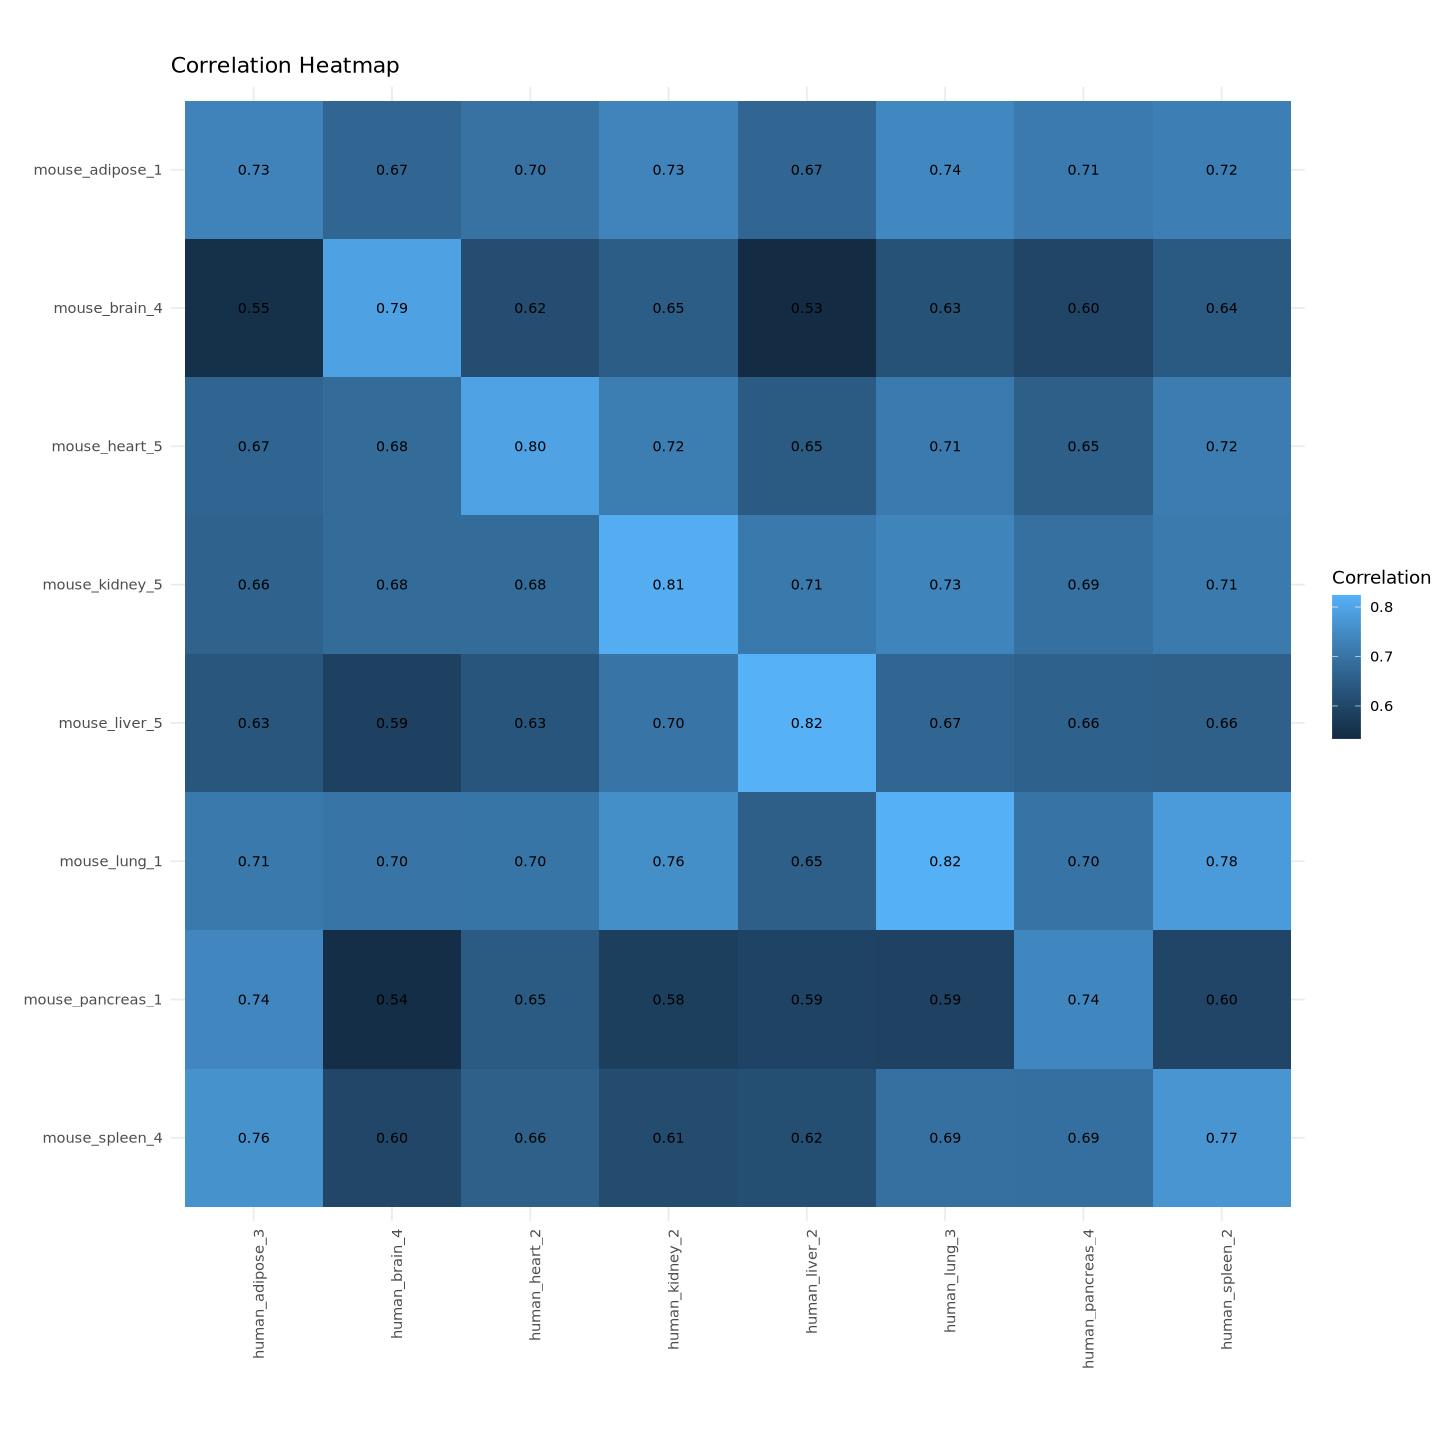

In [65]:
ggplot(long_data, aes(x = Var2, y = Var1, fill = value)) +
  geom_tile() +
  geom_text(aes(label = sprintf("%.2f", value)), size = 3) +
  # scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Correlation Heatmap",
       x = "", y = "", fill = "Correlation") +
  coord_fixed() +
  scale_y_discrete(limits = rev)